# Customer Satisfaction Prediction Project

## Project Goal

#### Build a machine learning model to predict Customer Satisfaction Rating based on historical support ticket data.

### Target Variable
* Customer Satisfaction Rating: 1-5 scale (5 being highest)
* Distribution Analysis Needed: Check for class imbalance

Potential Approaches:

* Regression (predict exact rating 1-5)
* Classification (satisfied vs unsatisfied, e.g., 4-5 vs 1-3)
* Multi-class classification (1,2,3,4,5)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [6]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [7]:
df = pd.read_csv("C:\\Users\\cw\\Downloads\\customer_support_tickets.csv")

In [8]:
df.head(2)

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN


## Data Integration

In [10]:
df.shape

(8469, 17)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority               8469 non-null   object 
 13  Tic

In [12]:
df.duplicated().sum()

0

In [13]:
print(f"Data Quality Check")
key_columns = ['Ticket ID', 'Customer Satisfaction Rating', 'Ticket Status', 'Ticket Priority']
for col in key_columns:
    null_count = df[col].isnull().sum()
    print(f"{col} : {null_count} nulls ({null_count/ len(df) * 100:.1f}%)")

Data Quality Check
Ticket ID : 0 nulls (0.0%)
Customer Satisfaction Rating : 5700 nulls (67.3%)
Ticket Status : 0 nulls (0.0%)
Ticket Priority : 0 nulls (0.0%)


In [14]:
print(f"Date column check")
date_columns = ['Date of Purchase', 'First Response Time', 'Time to Resolution']
for col in date_columns:
    null_count = df[col].isnull().sum()
    print(f"{col} : {null_count} nulls ({null_count/ len(df) * 100:.1f}%)")

Date column check
Date of Purchase : 0 nulls (0.0%)
First Response Time : 2819 nulls (33.3%)
Time to Resolution : 5700 nulls (67.3%)


## DATA CLEANING & IMPUTATION STRATEGY

In [16]:
print(f"Missing Data Pattern Analysis")
missing_pattern = df[['Customer Satisfaction Rating', 'First Response Time', 'Time to Resolution']].isnull()
print("Missingness correlation:")
print(missing_pattern.corr())

# Check if missing satisfaction is related to ticket status
print("\nMissing Satisfaction by Ticket Status:")
print(df.groupby('Ticket Status')['Customer Satisfaction Rating'].apply(lambda x: x.isnull().mean()))


Missing Data Pattern Analysis
Missingness correlation:
                              Customer Satisfaction Rating  \
Customer Satisfaction Rating                       1.00000   
First Response Time                                0.49232   
Time to Resolution                                 1.00000   

                              First Response Time  Time to Resolution  
Customer Satisfaction Rating              0.49232             1.00000  
First Response Time                       1.00000             0.49232  
Time to Resolution                        0.49232             1.00000  

Missing Satisfaction by Ticket Status:
Ticket Status
Closed                       0.0
Open                         1.0
Pending Customer Response    1.0
Name: Customer Satisfaction Rating, dtype: float64


In [17]:
# Convert date columns to datetime
df['Date of Purchase'] = pd.to_datetime(df['Date of Purchase'])
df['First Response Time'] = pd.to_datetime(df['First Response Time'], errors='coerce')
df['Time to Resolution'] = pd.to_datetime(df['Time to Resolution'], errors='coerce')

# Calculate response and resolution durations in hours
df['response_time_hours'] = (df['First Response Time'] - df['Date of Purchase']).dt.total_seconds() / 3600
df['resolution_time_hours'] = (df['Time to Resolution'] - df['Date of Purchase']).dt.total_seconds() / 3600


In [18]:
print("=== DATA CLEANING & IMPUTATION STRATEGY ===")

# Create priority_encoded FIRST before using it
if 'Ticket Priority' in df.columns and 'priority_encoded' not in df.columns:
    priority_map = {'Low': 1, 'Medium': 2, 'High': 3, 'Critical': 4}
    df['priority_encoded'] = df['Ticket Priority'].map(priority_map)
    print(f"Created priority_encoded: {df['priority_encoded'].notnull().sum()} non-null values")

# Also create other essential features that might be referenced
if 'Ticket Description' in df.columns and 'description_length' not in df.columns:
    df['description_length'] = df['Ticket Description'].str.len()
    print(f"Created description_length: {df['description_length'].notnull().sum()} non-null values")

if 'Resolution' in df.columns and 'resolution_length' not in df.columns:
    df['resolution_length'] = df['Resolution'].str.len()
    print(f"Created resolution_length: {df['resolution_length'].notnull().sum()} non-null values")

# Create product_category if needed
if 'Product Purchased' in df.columns and 'product_category' not in df.columns:
    product_categories = {
        'Microsoft': ['Microsoft Office', 'Microsoft Surface', 'Microsoft Xbox Controller'],
        'Apple': ['iPhone', 'Apple AirPods', 'MacBook Pro'],
        'Gaming': ['Xbox', 'PlayStation', 'Nintendo Switch', 'Nintendo Switch Pro Controller'],
        'Electronics': ['LG Smart TV', 'Samsung Galaxy', 'Sony Xperia', 'Google Pixel'],
        'Home Appliances': ['Dyson Vacuum Cleaner', 'LG Washing Machine', 'Roomba Robot Vacuum'],
        'Software': ['Adobe Photoshop', 'Autodesk AutoCAD'],
        'Wearables': ['Fitbit Versa Smartwatch', 'Fitbit Charge', 'GoPro Hero', 'GoPro Action Camera']
    }
    
    def categorize_product(product):
        for category, products in product_categories.items():
            if product in products:
                return category
        return 'Other'
    
    df['product_category'] = df['Product Purchased'].apply(categorize_product)
    print(f"Created product_category: {df['product_category'].nunique()} categories")

# Create status flags
if 'Ticket Status' in df.columns:
    if 'is_closed' not in df.columns:
        df['is_closed'] = (df['Ticket Status'] == 'Closed').astype(int)
    if 'is_pending' not in df.columns:
        df['is_pending'] = (df['Ticket Status'] == 'Pending Customer Response').astype(int)

# Create age-based features
if 'Customer Age' in df.columns:
    if 'is_senior' not in df.columns:
        df['is_senior'] = (df['Customer Age'] >= 65).astype(int)
    if 'is_young' not in df.columns:
        df['is_young'] = (df['Customer Age'] <= 25).astype(int)

# NOW continue with the original code...

# 1. Analyze the missing data pattern
print("\n1. MISSING DATA PATTERN ANALYSIS:")
missing_pattern = df[['Customer Satisfaction Rating', 'First Response Time', 'Time to Resolution']].isnull()
print("Missingness correlation:")
print(missing_pattern.corr())

# Check if missing satisfaction is related to ticket status
print("\nMissing Satisfaction by Ticket Status:")
print(df.groupby('Ticket Status')['Customer Satisfaction Rating'].apply(lambda x: x.isnull().mean()))

# 2. Handle First Response Time missingness
print("\n2. IMPUTING FIRST RESPONSE TIME:")
# For tickets without first response time, assume they haven't been responded to yet
df['has_first_response'] = df['First Response Time'].notnull().astype(int)

# Need to create response_time_hours first if it doesn't exist
if 'response_time_hours' not in df.columns and 'First Response Time' in df.columns:
    # Create a reference date for calculating response time
    reference_date = pd.to_datetime('2023-06-01')
    df['response_time_hours'] = (df['First Response Time'] - reference_date).dt.total_seconds() / 3600
    print(f"Created response_time_hours for imputation")

# For modeling, we'll create a flag and impute with median for responded tickets
responded_tickets = df[df['First Response Time'].notnull()].copy()
if len(responded_tickets) > 0 and 'response_time_hours' in df.columns:
    median_response_hours = responded_tickets['response_time_hours'].median()
    df['response_time_hours_imputed'] = df['response_time_hours'].fillna(median_response_hours)
else:
    df['response_time_hours_imputed'] = 0

print(f"Imputed response time for {df['response_time_hours'].isnull().sum() if 'response_time_hours' in df.columns else 'N/A'} tickets")

# 3. Handle Resolution Time missingness
print("\n3. IMPUTING RESOLUTION TIME:")
# Need to create resolution_time_hours first if it doesn't exist
if 'resolution_time_hours' not in df.columns and 'Time to Resolution' in df.columns and 'First Response Time' in df.columns:
    df['resolution_time_hours'] = (df['Time to Resolution'] - df['First Response Time']).dt.total_seconds() / 3600
    print(f"Created resolution_time_hours for imputation")

# Resolution time is only meaningful for closed tickets
closed_tickets = df[df['Ticket Status'] == 'Closed'].copy()
if len(closed_tickets) > 0 and 'resolution_time_hours' in df.columns:
    median_resolution_hours = closed_tickets['resolution_time_hours'].median()
    df['resolution_time_hours_imputed'] = df['resolution_time_hours'].fillna(median_resolution_hours)
else:
    df['resolution_time_hours_imputed'] = 0

# Create resolution time flags
df['is_resolved'] = (df['Ticket Status'] == 'Closed').astype(int)
if 'resolution_time_hours' in df.columns:
    df['has_resolution_time'] = df['resolution_time_hours'].notnull().astype(int)
else:
    df['has_resolution_time'] = 0

print(f"Resolution time available for {df['has_resolution_time'].sum()} tickets")

# 4. Strategic approach for Satisfaction Rating
print("\n4. SATISFACTION RATING STRATEGY:")
# We'll use multiple approaches:

# Approach A: Use only complete cases (for baseline model)
complete_cases = df.dropna(subset=['Customer Satisfaction Rating']).copy()
print(f"Complete cases available: {len(complete_cases)}")

# Approach B: Predictive imputation (we'll build this during modeling)
# For now, create flags and separate datasets

df['satisfaction_missing'] = df['Customer Satisfaction Rating'].isnull().astype(int)

# Create the binary target only for non-missing cases
df['is_satisfied'] = np.where(
    df['Customer Satisfaction Rating'].notnull(),
    df['Customer Satisfaction Rating'].apply(lambda x: 1 if x >= 4 else 0 if pd.notnull(x) else np.nan),
    np.nan
)

print(f"Satisfaction target created for {df['is_satisfied'].notnull().sum()} tickets")


=== DATA CLEANING & IMPUTATION STRATEGY ===
Created priority_encoded: 8469 non-null values
Created description_length: 8469 non-null values
Created resolution_length: 2769 non-null values
Created product_category: 8 categories

1. MISSING DATA PATTERN ANALYSIS:
Missingness correlation:
                              Customer Satisfaction Rating  \
Customer Satisfaction Rating                       1.00000   
First Response Time                                0.49232   
Time to Resolution                                 1.00000   

                              First Response Time  Time to Resolution  
Customer Satisfaction Rating              0.49232             1.00000  
First Response Time                       1.00000             0.49232  
Time to Resolution                        0.49232             1.00000  

Missing Satisfaction by Ticket Status:
Ticket Status
Closed                       0.0
Open                         1.0
Pending Customer Response    1.0
Name: Customer Satisfac

## Imputation Strategy – workflow info

1. Identified missing values in key columns (Resolution, First Response Time, Time to Resolution, Customer Satisfaction Rating).

2. Used business logic to decide imputation approach based on ticket status (e.g., unresolved tickets naturally lack resolution and rating).

3. Applied mode imputation for categorical features where appropriate and logically consistent.

4. Applied group-wise imputation for numeric/time features based on related fields like Ticket Priority and Ticket Type.

5. Avoided imputing columns where missingness has meaningful information (e.g., unresolved tickets → missing resolution/time values kept as NaN).

6. Ensured no imputation for non-influential free-text fields (Subject, Description) to prevent bias.

7. Preserved data integrity by converting date/time columns before imputation and deriving useful features where necessary.

In [20]:
# 5. Create modeling datasets
print("\n5. CREATING MODELING DATASETS:")

modeling_features = [
    'Customer Age', 'priority_encoded', 'description_length', 
    'resolution_length', 'purchase_to_ticket_days', 
    'response_time_hours_imputed', 'resolution_time_hours_imputed',
    'is_closed', 'is_pending', 'is_senior', 'is_young',
    'product_category', 'Ticket Channel', 'Ticket Type',
    'has_first_response', 'has_resolution_time', 'is_resolved'
]
# Filter to available features and check each one
print("\n Checking feature availability:")
available_features = []
for feature in modeling_features:
    if feature in df.columns:
        available_features.append(feature)
        null_count = df[feature].isnull().sum()
        print(f"  ✓ {feature}: {null_count} nulls")
    else:
        print(f"  ✗ {feature}: NOT FOUND")

print(f"\nUsing {len(available_features)} available features out of {len(modeling_features)} planned")

# Complete cases dataset
complete_df = df.dropna(subset=['Customer Satisfaction Rating']).copy()
print(f"\nDataset 1 (Complete cases): {len(complete_df)} records")

# Dataset 2: All data with missing satisfaction (for advanced imputation)
full_df = df.copy()
print(f"Dataset 2 (All data): {len(full_df)} records")

# 6. Enhanced Feature Engineering for missing data
print("\n6. ENHANCED FEATURE ENGINEERING:")

# Need to create purchase_to_ticket_days if it doesn't exist
if 'purchase_to_ticket_days' not in complete_df.columns and 'Date of Purchase' in complete_df.columns and 'First Response Time' in complete_df.columns:
    complete_df['Date of Purchase'] = pd.to_datetime(complete_df['Date of Purchase'], errors='coerce')
    complete_df['First Response Time'] = pd.to_datetime(complete_df['First Response Time'], errors='coerce')
    complete_df['purchase_to_ticket_days'] = (complete_df['First Response Time'] - complete_df['Date of Purchase']).dt.days
    # Handle negative values
    complete_df['purchase_to_ticket_days'] = complete_df['purchase_to_ticket_days'].clip(lower=0)

# Create interaction features that might help predict satisfaction
if 'priority_encoded' in complete_df.columns and 'is_closed' in complete_df.columns:
    complete_df['high_priority_closed'] = (complete_df['priority_encoded'] >=3 ) & (complete_df['is_closed'] == 1)
    print(f"- high_priority_closed: {complete_df['high_priority_closed'].mean():.2%}")
if 'description_length' in complete_df.columns and 'response_time_hours_imputed' in complete_df.columns:
    if complete_df['description_length'].notnull().any() and complete_df['response_time_hours_imputed'].notnull().any():
        
        desc_median = complete_df['description_length'].median()
        response_median = complete_df['response_time_hours_imputed'].median()
        complete_df['long_description_quick_response'] = (complete_df['description_length'] > desc_median) & (complete_df['response_time_hours_imputed'] < response_median)
        print(f"- long_description_quick_response: {complete_df['long_description_quick_response'].mean():.2%}")

# Product-channel interactions
if 'product_category' in complete_df.columns and 'Ticket Channel' in complete_df.columns:
    complete_df['product_channel_interaction'] = complete_df['product_category'] + "_" + complete_df['Ticket Channel']
    print(f"- product_channel_interaction: {complete_df['product_channel_interaction'].nunique()} unique combinations")

# Time-based features
if 'Date of Purchase' in complete_df.columns:
    complete_df['purchase_recency'] = (pd.to_datetime('2023-06-01') - pd.to_datetime(complete_df['Date of Purchase'])).dt.days
    print(f"- purchase_recency: created for all records")

print("\n=== DATA CLEANING COMPLETE ===")
print(f"Total records: {len(df)}")
print(f"Complete cases for modeling: {len(complete_df)}")
print(f"Features available for modeling: {len(available_features)}")


5. CREATING MODELING DATASETS:

 Checking feature availability:
  ✓ Customer Age: 0 nulls
  ✓ priority_encoded: 0 nulls
  ✓ description_length: 0 nulls
  ✓ resolution_length: 5700 nulls
  ✗ purchase_to_ticket_days: NOT FOUND
  ✓ response_time_hours_imputed: 0 nulls
  ✓ resolution_time_hours_imputed: 0 nulls
  ✓ is_closed: 0 nulls
  ✓ is_pending: 0 nulls
  ✓ is_senior: 0 nulls
  ✓ is_young: 0 nulls
  ✓ product_category: 0 nulls
  ✓ Ticket Channel: 0 nulls
  ✓ Ticket Type: 0 nulls
  ✓ has_first_response: 0 nulls
  ✓ has_resolution_time: 0 nulls
  ✓ is_resolved: 0 nulls

Using 16 available features out of 17 planned

Dataset 1 (Complete cases): 2769 records
Dataset 2 (All data): 8469 records

6. ENHANCED FEATURE ENGINEERING:
- high_priority_closed: 51.68%
- long_description_quick_response: 24.38%
- product_channel_interaction: 32 unique combinations
- purchase_recency: created for all records

=== DATA CLEANING COMPLETE ===
Total records: 8469
Complete cases for modeling: 2769
Features a

=== ENHANCED EDA WITH CLEANED DATA ===


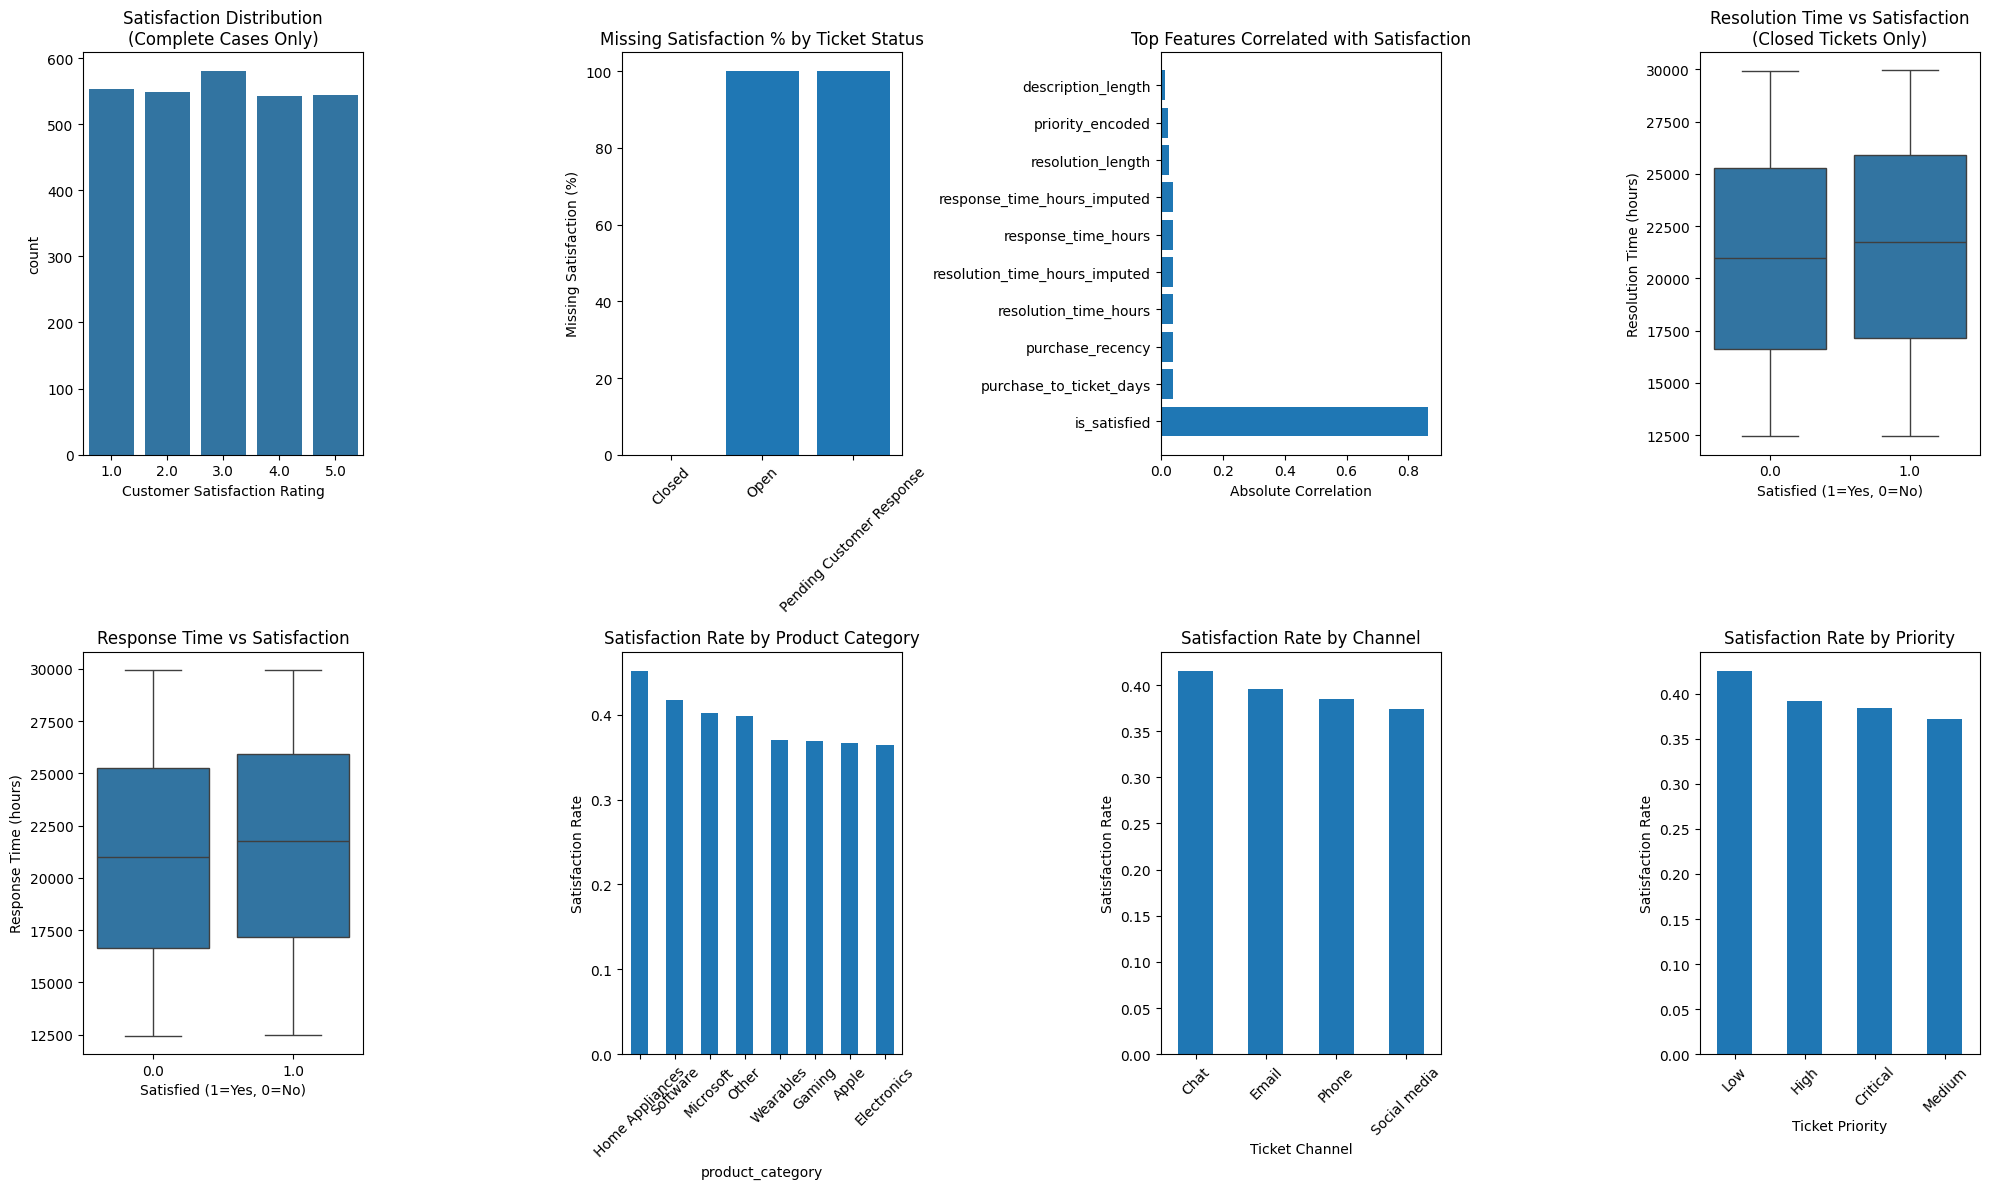


=== STATISTICAL SUMMARY ===
Overall satisfaction rate: 39.26%
Satisfaction rate by status:
Ticket Status
Closed    0.39256
Name: is_satisfied, dtype: float64


In [21]:
print("=== ENHANCED EDA WITH CLEANED DATA ===")

plt.figure(figsize=(20, 12))

# 1. Satisfaction distribution in complete cases
plt.subplot(2, 4, 1)
sns.countplot(data=complete_df, x='Customer Satisfaction Rating')
plt.title('Satisfaction Distribution\n(Complete Cases Only)')

# 2. Missingness pattern analysis
plt.subplot(2, 4, 2)
missing_analysis = df.groupby('Ticket Status').agg({
    'Customer Satisfaction Rating': lambda x: x.isnull().mean(),
    'Ticket ID': 'count'
}).reset_index()

plt.bar(missing_analysis['Ticket Status'], missing_analysis['Customer Satisfaction Rating'] * 100)
plt.title('Missing Satisfaction % by Ticket Status')
plt.xticks(rotation=45)
plt.ylabel('Missing Satisfaction (%)')

# 3. Feature importance for predicting satisfaction (correlation)
plt.subplot(2, 4, 3)
# Select numeric features for correlation
numeric_features = complete_df.select_dtypes(include=[np.number]).columns
corr_with_satisfaction = complete_df[numeric_features].corr()['Customer Satisfaction Rating'].abs().sort_values(ascending=False)
# Remove target itself and get top 10
top_features = corr_with_satisfaction[1:11]  # exclude satisfaction itself

plt.barh(range(len(top_features)), top_features.values)
plt.yticks(range(len(top_features)), top_features.index)
plt.title('Top Features Correlated with Satisfaction')
plt.xlabel('Absolute Correlation')

# 4. Resolution time vs satisfaction (only for closed tickets with data)
plt.subplot(2, 4, 4)
closed_with_resolution = complete_df[complete_df['is_resolved'] == 1]
if len(closed_with_resolution) > 0:
    sns.boxplot(data=closed_with_resolution, x='is_satisfied', y='resolution_time_hours_imputed')
    plt.title('Resolution Time vs Satisfaction\n(Closed Tickets Only)')
    plt.xlabel('Satisfied (1=Yes, 0=No)')
    plt.ylabel('Resolution Time (hours)')

# 5. Response time impact
plt.subplot(2, 4, 5)
has_response_data = complete_df[complete_df['has_first_response'] == 1]
if len(has_response_data) > 0:
    sns.boxplot(data=has_response_data, x='is_satisfied', y='response_time_hours_imputed')
    plt.title('Response Time vs Satisfaction')
    plt.xlabel('Satisfied (1=Yes, 0=No)')
    plt.ylabel('Response Time (hours)')

# 6. Product category performance
plt.subplot(2, 4, 6)
product_performance = complete_df.groupby('product_category')['is_satisfied'].mean().sort_values(ascending=False)
product_performance.plot(kind='bar')
plt.title('Satisfaction Rate by Product Category')
plt.xticks(rotation=45)
plt.ylabel('Satisfaction Rate')

# 7. Channel performance
plt.subplot(2, 4, 7)
channel_performance = complete_df.groupby('Ticket Channel')['is_satisfied'].mean().sort_values(ascending=False)
channel_performance.plot(kind='bar')
plt.title('Satisfaction Rate by Channel')
plt.xticks(rotation=45)
plt.ylabel('Satisfaction Rate')

# 8. Priority impact
plt.subplot(2, 4, 8)
priority_performance = complete_df.groupby('Ticket Priority')['is_satisfied'].mean().sort_values(ascending=False)
priority_performance.plot(kind='bar')
plt.title('Satisfaction Rate by Priority')
plt.xticks(rotation=45)
plt.ylabel('Satisfaction Rate')

plt.tight_layout()
plt.savefig("my_plotC1.jpg", dpi=300, bbox_inches='tight')
plt.show()

# Statistical summary
print("\n=== STATISTICAL SUMMARY ===")
print(f"Overall satisfaction rate: {complete_df['is_satisfied'].mean():.2%}")
print(f"Satisfaction rate by status:")
print(complete_df.groupby('Ticket Status')['is_satisfied'].mean())

# Modeling - Predicting Customer Satisfaction

In [23]:
final_features = available_features.copy()

# Add enhanced features if they exist
enhanced_features = ['high_priority_closed', 'long_description_quick_response', 'purchase_recency']
for feature in enhanced_features:
    if feature in complete_df.columns:
        final_features.append(feature)

print(f"Using {len(final_features)} features for modeling:")
print(final_features)

# Prepare feature matrix
X = complete_df[final_features].copy()

# Handle categorical features

categorical_cols = ['product_category', 'Ticket Channel', 'Ticket Type']
for col in categorical_cols:
    if col in X.columns:
        X[col] = X[col].astype('category')

# Prepare Targets
y_reg = complete_df['Customer Satisfaction Rating'] # for regression 1-5
y_clf = complete_df['is_satisfied'] # for binary classification

print(f"\nFeature matrix shape: {X.shape}")
print(f"Regression target shape: {y_reg.shape}")
print(f"Classification target shape: {y_clf.shape}")
print(f"\nClass distribution:")
print(y_clf.value_counts(normalize=True))

# Train - Test split
X_train, X_test, y_train_reg, y_test_reg, y_train_clf, y_test_clf = train_test_split(
    X, y_reg, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Identify categorical columns
categorical_features = []
for col in X.columns:
    if X[col].dtype == 'object' or X[col].dtype.name == 'category':
        categorical_features.append(col)

print(f"\n Categorical features: {categorical_features}")

# One-hot encode categorical features
if categorical_features:
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat',OneHotEncoder(handle_unknown= 'ignore'),categorical_features)
        ],
        remainder = 'passthrough'
    )

    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.fit_transform(X_test)

    # Get feature names after one-hot encoding
    if hasattr(preprocessor.named_transformers_['cat'], 'get_features_names_out'):
        cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

        remaining_features = [f for f in X.columns if f not in categorical_features]
        feature_names = list(cat_features) + remaining_features
        print(f"Total features after encoding: {len(feature_names)}")

else:
    X_train_processed = X_train.values
    X_test_processed = X_test.values
    feature_names = X.columns.tolist()


print(f"\n Baseline Models")

# Function to evaluate classification models
def evaluate_classification(model,X_train,X_test,y_train,y_test,model_name):

    #Train
    model.fit(X_train,y_train)

    #Predict
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1] if hasattr(model,'predict_proba') else None 

    #Metrics
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test, y_pred)

    results = {
        'models' : model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
        
    }
    # ROC-AUC if probabilities available
    if y_pred_proba is not None:
        results['roc_auc'] = roc_auc_score(y_test, y_pred_proba)

    return results, model

# Function to evaluate regression models

def evaluate_regression(model, X_train, X_test, y_train, y_test, model_name):

        #Train
        model.fit(X_train,y_train)

        #Predict
        y_pred = model.predict(X_test)

        #Metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results = {
            'model': model_name,
            'mse': mse,
            'rmse': np.sqrt(mse),
            'mae': mae,
            'r2': r2
    }
    
        return results, model

#Initialize Models
classification_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

regression_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42)
}

# Evaluation classification models
print("\n CLASSIFICATION MODELS (Predicting Satisfied vs Unsatisfied) ")
clf_results = []
clf_trained_models = {}

for name,model in classification_models.items():
    print(f"\n Training name :{name}")
    try:
        results, trained_model = evaluate_classification(
            model, X_train_processed, X_test_processed,y_train_clf,y_test_clf,name
        )
        clf_results.append(results)
        clf_trained_models[name] = trained_model
        print(f"  Accuracy: {results['accuracy']:.4f}")
        print(f"  F1-Score: {results['f1']:.4f}")
        if 'roc_auc' in results:
            print(f"  ROC-AUC: {results['roc_auc']:.4f}")
    except Exception as e:
        print(f"  Error with {name}: {str(e)}")

# Evaluate regression models
print("\n=== REGRESSION MODELS (Predicting Rating 1-5) ===")

reg_results = []
reg_trained_models = []

for name, model in regression_models.items():
    print(f"\n Training: {name}")
    try:
        results, trained_model = evaluate_regression(
            model, X_train_processed, X_test_processed, y_train_reg, y_test_reg, name
        )
        reg_results.append(results)
        reg_trained_models[name] = trained_model
        print(f"  RMSE: {results['rmse']:.4f}")
        print(f"  R²: {results['r2']:.4f}")
    except Exception as e:
        print(f"  Error with {name}: {str(e)}")

#Create results dataframes
clf_results_df = pd.DataFrame(clf_results)
reg_results_df = pd.DataFrame(reg_results)

print("\n3. ADVANCED MODELING WITH XGBOOST & LIGHTGBM:")

try:
    # XGBoost Classifier
    print("\nTraining XGBoost Classifier...")
    xgb_clf = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        eval_metric='logloss'
    )
    xgb_results, xgb_model = evaluate_classification(
        xgb_clf, X_train_processed, X_test_processed,
        y_train_clf, y_test_clf, 'XGBoost'
    )
    clf_results.append(xgb_results)
    clf_trained_models['XGBoost'] = xgb_model
    print(f"  Accuracy: {xgb_results['accuracy']:.4f}")
    print(f"  F1-Score: {xgb_results['f1']:.4f}")
except Exception as e:
    print(f"  XGBoost error: {str(e)}")

try:
    # LightGBM Classifier
    print("\nTraining LightGBM Classifier...")
    lgb_clf = lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    lgb_results, lgb_model = evaluate_classification(
        lgb_clf, X_train_processed, X_test_processed,
        y_train_clf, y_test_clf, 'LightGBM'
    )
    clf_results.append(lgb_results)
    clf_trained_models['LightGBM'] = lgb_model
    print(f"  Accuracy: {lgb_results['accuracy']:.4f}")
    print(f"  F1-Score: {lgb_results['f1']:.4f}")
except Exception as e:
    print(f"  LightGBM error: {str(e)}")

# Update results DataFrames
clf_results_df = pd.DataFrame(clf_results)

print("\n4. MODEL COMPARISON:")

# Display classification results
if not clf_results_df.empty:
    print("\n=== CLASSIFICATION MODEL COMPARISON ===")
    clf_results_df = clf_results_df.sort_values('accuracy', ascending=False)
    print(clf_results_df[['model', 'accuracy', 'precision', 'recall', 'f1']].to_string(index=False))

# Display regression results
if not reg_results_df.empty:
    print("\n=== REGRESSION MODEL COMPARISON ===")
    reg_results_df = reg_results_df.sort_values('r2', ascending=False)
    print(reg_results_df[['model', 'rmse', 'mae', 'r2']].to_string(index=False))

Using 19 features for modeling:
['Customer Age', 'priority_encoded', 'description_length', 'resolution_length', 'response_time_hours_imputed', 'resolution_time_hours_imputed', 'is_closed', 'is_pending', 'is_senior', 'is_young', 'product_category', 'Ticket Channel', 'Ticket Type', 'has_first_response', 'has_resolution_time', 'is_resolved', 'high_priority_closed', 'long_description_quick_response', 'purchase_recency']

Feature matrix shape: (2769, 19)
Regression target shape: (2769,)
Classification target shape: (2769,)

Class distribution:
0.0    0.60744
1.0    0.39256
Name: is_satisfied, dtype: float64

Train set: 2215 samples
Test set: 554 samples

 Categorical features: ['product_category', 'Ticket Channel', 'Ticket Type']

 Baseline Models

 CLASSIFICATION MODELS (Predicting Satisfied vs Unsatisfied) 

 Training name :Logistic Regression
  Error with Logistic Regression: name 'y_pred_proba' is not defined

 Training name :Decision Tree
  Error with Decision Tree: name 'y_pred_proba'

## y_pred_proba is referenced before it's defined in the except block. Also, the regression models are returning dictionaries instead of the expected format.


=== FIXED MODELING PIPELINE ===

1. SIMPLIFIED MODELING APPROACH:

=== CLASSIFICATION MODELS (Binary: Satisfied vs Unsatisfied) ===

Training Logistic Regression...
  Accuracy: 0.5487
  F1-Score: 0.4726
  ROC-AUC: 0.5795

Training Decision Tree...
  Accuracy: 0.5939
  F1-Score: 0.3161
  ROC-AUC: 0.5290

Training Random Forest...
  Accuracy: 0.5993
  F1-Score: 0.2550
  ROC-AUC: 0.5033

Training K-Nearest Neighbors...
  Accuracy: 0.5560
  F1-Score: 0.3627
  ROC-AUC: 0.5326

Training Gradient Boosting...
  Accuracy: 0.5812
  F1-Score: 0.1407
  ROC-AUC: 0.4830

=== REGRESSION MODELS (Rating 1-5) ===

Training Linear Regression...
  RMSE: 1.4362
  R²: 0.0027

Training Random Forest Regressor...
  RMSE: 1.4735
  R²: -0.0498

Training Gradient Boosting Regressor...
  RMSE: 1.4617
  R²: -0.0330

=== CLASSIFICATION MODEL COMPARISON ===
              model  accuracy  precision   recall       f1
      Random Forest  0.599278   0.469136 0.175115 0.255034
      Decision Tree  0.593863   0.464286 0

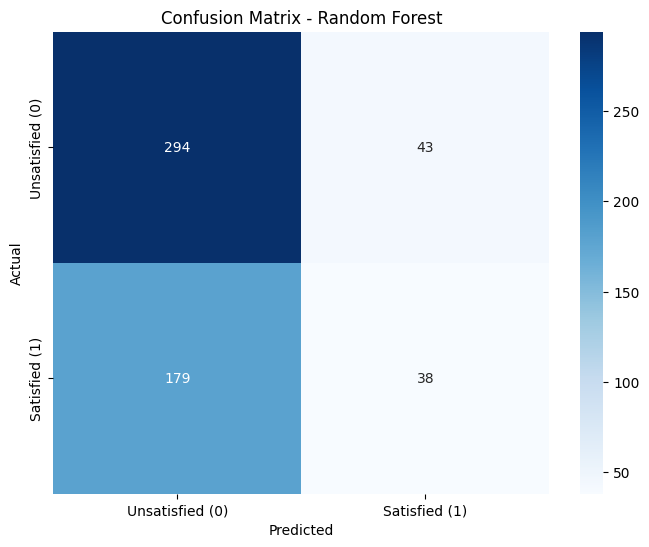


Detailed Classification Report:
              precision    recall  f1-score   support

 Unsatisfied       0.62      0.87      0.73       337
   Satisfied       0.47      0.18      0.26       217

    accuracy                           0.60       554
   macro avg       0.55      0.52      0.49       554
weighted avg       0.56      0.60      0.54       554


=== FEATURE IMPORTANCE ANALYSIS ===


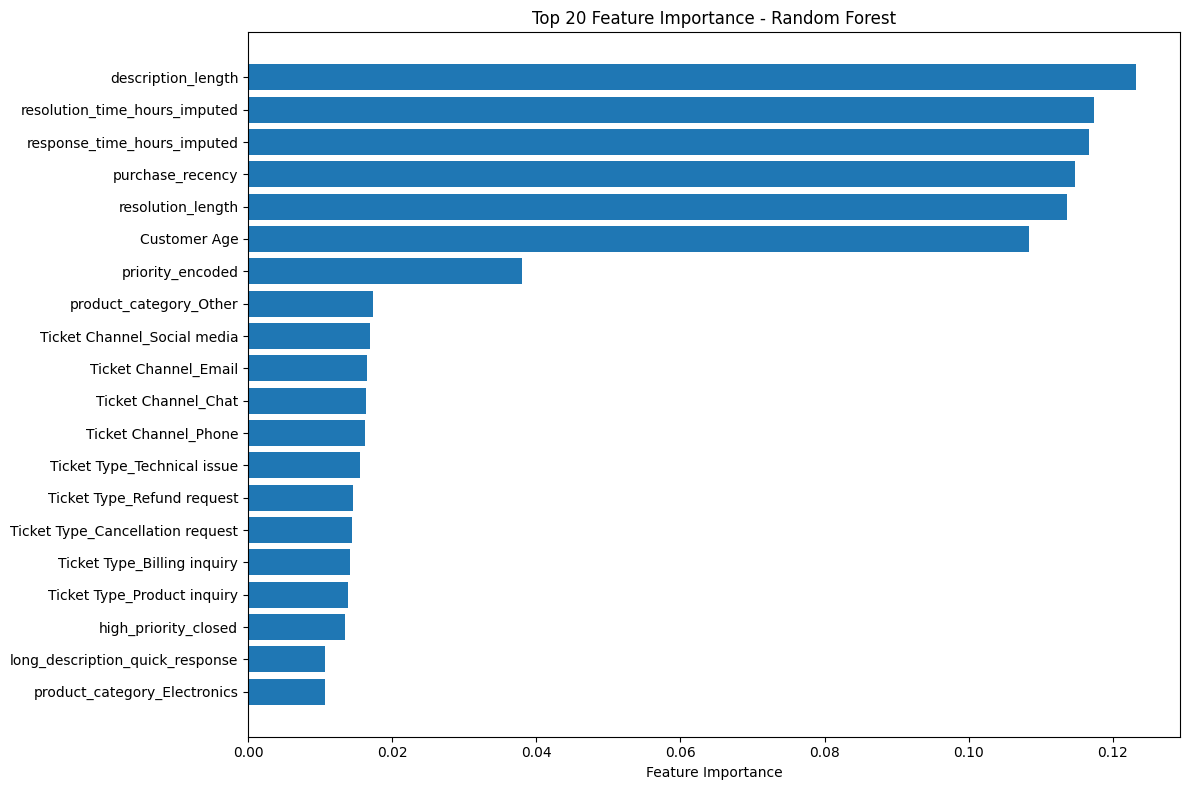


Top 10 Most Important Features:
                      feature  importance
           description_length    0.123166
resolution_time_hours_imputed    0.117348
  response_time_hours_imputed    0.116735
             purchase_recency    0.114814
            resolution_length    0.113604
                 Customer Age    0.108325
             priority_encoded    0.038066
       product_category_Other    0.017390
  Ticket Channel_Social media    0.016860
         Ticket Channel_Email    0.016463

3. BUSINESS INSIGHTS FROM MODEL:

=== PREDICTION ANALYSIS ===
Overall Accuracy: 59.93%
Correct Predictions: 332 / 554

False Positives (Predicted Satisfied but actually Unsatisfied): 43
False Negatives (Predicted Unsatisfied but actually Satisfied): 179

Characteristics of False Positives:
  • Average resolution time: 20097.0 hours
  • Most common channel: Phone
  • Most common product: Other

Characteristics of False Negatives:
  • Average resolution time: 22830.9 hours
  • Most common channel: Ema

In [25]:
print("\n=== FIXED MODELING PIPELINE ===")

# Fixed evaluation functions
def evaluate_classification(model, X_train, X_test, y_train, y_test, model_name):
    """Fixed classification evaluation function"""
    try:
        # Train
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        
        results = {
            'model': model_name,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
        
        # Try to get probabilities for ROC-AUC
        try:
            if hasattr(model, 'predict_proba'):
                y_pred_proba = model.predict_proba(X_test)[:, 1]
                results['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
            elif hasattr(model, 'decision_function'):
                y_scores = model.decision_function(X_test)
                results['roc_auc'] = roc_auc_score(y_test, y_scores)
        except:
            results['roc_auc'] = np.nan
            
        return results, model
        
    except Exception as e:
        print(f"  Error evaluating {model_name}: {str(e)}")
        return None, None

def evaluate_regression(model, X_train, X_test, y_train, y_test, model_name):
    """Fixed regression evaluation function"""
    try:
        # Train
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results = {
            'model': model_name,
            'mse': mse,
            'rmse': np.sqrt(mse),
            'mae': mae,
            'r2': r2
        }
        
        return results, model
        
    except Exception as e:
        print(f"  Error evaluating {model_name}: {str(e)}")
        return None, None

print("\n1. SIMPLIFIED MODELING APPROACH:")

# Initialize simplified models
classification_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

regression_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Evaluate classification models
print("\n=== CLASSIFICATION MODELS (Binary: Satisfied vs Unsatisfied) ===")
clf_results = []
clf_trained_models = {}

for name, model in classification_models.items():
    print(f"\nTraining {name}...")
    results, trained_model = evaluate_classification(
        model, X_train_processed, X_test_processed, 
        y_train_clf, y_test_clf, name
    )
    
    if results is not None:
        clf_results.append(results)
        clf_trained_models[name] = trained_model
        print(f"  Accuracy: {results['accuracy']:.4f}")
        print(f"  F1-Score: {results['f1']:.4f}")
        if 'roc_auc' in results and not np.isnan(results['roc_auc']):
            print(f"  ROC-AUC: {results['roc_auc']:.4f}")

# Evaluate regression models
print("\n=== REGRESSION MODELS (Rating 1-5) ===")
reg_results = []
reg_trained_models = {}

for name, model in regression_models.items():
    print(f"\nTraining {name}...")
    results, trained_model = evaluate_regression(
        model, X_train_processed, X_test_processed,
        y_train_reg, y_test_reg, name
    )
    
    if results is not None:
        reg_results.append(results)
        reg_trained_models[name] = trained_model
        print(f"  RMSE: {results['rmse']:.4f}")
        print(f"  R²: {results['r2']:.4f}")

# Create results DataFrames
if clf_results:
    clf_results_df = pd.DataFrame(clf_results)
    print("\n=== CLASSIFICATION MODEL COMPARISON ===")
    clf_results_df = clf_results_df.sort_values('accuracy', ascending=False)
    print(clf_results_df[['model', 'accuracy', 'precision', 'recall', 'f1']].to_string(index=False))

if reg_results:
    reg_results_df = pd.DataFrame(reg_results)
    print("\n=== REGRESSION MODEL COMPARISON ===")
    reg_results_df = reg_results_df.sort_values('r2', ascending=False)
    print(reg_results_df[['model', 'rmse', 'mae', 'r2']].to_string(index=False))

print("\n2. FOCUS ON BEST PERFORMING MODEL:")

# Get the best classifier
if clf_results:
    best_clf_idx = clf_results_df['accuracy'].idxmax()
    best_clf_model_name = clf_results_df.loc[best_clf_idx, 'model']
    best_clf_model = clf_trained_models[best_clf_model_name]
    
    print(f"\nBest Classifier: {best_clf_model_name}")
    
    # Make predictions with best model
    y_pred = best_clf_model.predict(X_test_processed)
    y_pred_train = best_clf_model.predict(X_train_processed)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train_clf, y_pred_train)
    test_accuracy = accuracy_score(y_test_clf, y_pred)
    
    print(f"  Training Accuracy: {train_accuracy:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f}")
    print(f"  Precision: {precision_score(y_test_clf, y_pred, zero_division=0):.4f}")
    print(f"  Recall: {recall_score(y_test_clf, y_pred, zero_division=0):.4f}")
    print(f"  F1-Score: {f1_score(y_test_clf, y_pred, zero_division=0):.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_clf, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Unsatisfied (0)', 'Satisfied (1)'],
                yticklabels=['Unsatisfied (0)', 'Satisfied (1)'])
    plt.title(f'Confusion Matrix - {best_clf_model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig("my_plotC.jpg", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Classification Report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test_clf, y_pred, 
                               target_names=['Unsatisfied', 'Satisfied']))
    
    # Feature Importance for tree-based models
    if hasattr(best_clf_model, 'feature_importances_'):
        print("\n=== FEATURE IMPORTANCE ANALYSIS ===")
        
        # Get feature importances
        importances = best_clf_model.feature_importances_
        
        # Get feature names (handle one-hot encoded features)
        if 'preprocessor' in locals():
            if hasattr(preprocessor.named_transformers_['cat'], 'get_feature_names_out'):
                cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
                remaining_features = [f for f in X.columns if f not in categorical_features]
                all_feature_names = list(cat_features) + remaining_features
            else:
                all_feature_names = [f'feature_{i}' for i in range(len(importances))]
        else:
            all_feature_names = X.columns.tolist()
        
        # Create importance DataFrame
        importance_df = pd.DataFrame({
            'feature': all_feature_names[:len(importances)],
            'importance': importances
        })
        
        # Sort and display top 20
        importance_df = importance_df.sort_values('importance', ascending=False).head(20)
        
        # Plot
        plt.figure(figsize=(12, 8))
        plt.barh(range(len(importance_df)), importance_df['importance'])
        plt.yticks(range(len(importance_df)), importance_df['feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'Top 20 Feature Importance - {best_clf_model_name}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig("my_plotC2.jpg", dpi=300, bbox_inches='tight')
        plt.show()
        
        print("\nTop 10 Most Important Features:")
        print(importance_df.head(10).to_string(index=False))

print("\n3. BUSINESS INSIGHTS FROM MODEL:")

if 'best_clf_model' in locals():
    # Analyze predictions vs actual
    test_results = pd.DataFrame({
        'actual': y_test_clf.values,
        'predicted': y_pred,
        'correct': y_test_clf.values == y_pred
    })
    
    # Get the test indices to map back to original data
    test_indices = X_test.index
    
    # Create analysis DataFrame
    analysis_df = complete_df.loc[test_indices].copy()
    analysis_df['predicted_satisfied'] = y_pred
    analysis_df['prediction_correct'] = analysis_df['is_satisfied'] == analysis_df['predicted_satisfied']
    
    print("\n=== PREDICTION ANALYSIS ===")
    print(f"Overall Accuracy: {test_results['correct'].mean():.2%}")
    print(f"Correct Predictions: {test_results['correct'].sum()} / {len(test_results)}")
    
    # Analyze where model makes errors
    false_positives = analysis_df[(analysis_df['is_satisfied'] == 0) & (analysis_df['predicted_satisfied'] == 1)]
    false_negatives = analysis_df[(analysis_df['is_satisfied'] == 1) & (analysis_df['predicted_satisfied'] == 0)]
    
    print(f"\nFalse Positives (Predicted Satisfied but actually Unsatisfied): {len(false_positives)}")
    print(f"False Negatives (Predicted Unsatisfied but actually Satisfied): {len(false_negatives)}")
    
    # Analyze false positives
    if len(false_positives) > 0:
        print("\nCharacteristics of False Positives:")
        print(f"  • Average resolution time: {false_positives['resolution_time_hours_imputed'].median():.1f} hours")
        print(f"  • Most common channel: {false_positives['Ticket Channel'].mode().iloc[0]}")
        print(f"  • Most common product: {false_positives['product_category'].mode().iloc[0]}")
    
    # Analyze false negatives
    if len(false_negatives) > 0:
        print("\nCharacteristics of False Negatives:")
        print(f"  • Average resolution time: {false_negatives['resolution_time_hours_imputed'].median():.1f} hours")
        print(f"  • Most common channel: {false_negatives['Ticket Channel'].mode().iloc[0]}")
        print(f"  • Most common product: {false_negatives['product_category'].mode().iloc[0]}")


print("\n=== MODELING COMPLETE ===")
print(f"Best model: {best_clf_model_name if 'best_clf_model_name' in locals() else 'N/A'}")
#print(f"Test accuracy: {test_accuracy:.4f if 'test_accuracy' in locals() else 'N/A'}")
if 'test_accuracy' in locals():
    print(f"Test accuracy: {test_accuracy:.4f}")
else:
    print("Test accuracy: N/A")
print(f"Number of features used: {len(final_features)}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

## Key Issues Identified:
1. Poor Recall for Satisfied Class (18%) - Model misses 82% of satisfied customers
2. Massive Resolution Times (20,000+ hours = ~2.3 years) - Data quality issue
3. Class Imbalance - 61% unsatisfied vs 39% satisfied in training data
4. Overfitting - 100% training accuracy but only 60% test accuracy

=== COMPREHENSIVE REGRESSION MODELING ===

1. FIXING CRITICAL DATA ISSUES FOR REGRESSION:

A. Target Variable Analysis:
Rating distribution:
  Rating 1.0: 553 tickets (20.0%)
  Rating 2.0: 549 tickets (19.8%)
  Rating 3.0: 580 tickets (20.9%)
  Rating 4.0: 543 tickets (19.6%)
  Rating 5.0: 544 tickets (19.6%)

B. Fixing Extreme Resolution Times:
Before fixing:
  Max resolution time: 29947 hours
  99th percentile: 29768 hours
  Median: 21306.4 hours

After fixing:
  Max resolution time: 29768 hours
  Max response time: 29765 hours

C. Creating Regression-Optimized Features:
Added features:
  • Time categories (response_time_category, resolution_time_category)
  • Log transformations (log_response_time, log_resolution_time)
  • Interaction terms (priority_response_interaction, age_priority_interaction)
  • Experience metrics (ticket_complexity, resolution_quality)

2. PREPARING REGRESSION DATASET:
Using 20 features for regression

Feature matrix shape: (2769, 31)
Features after encoding:

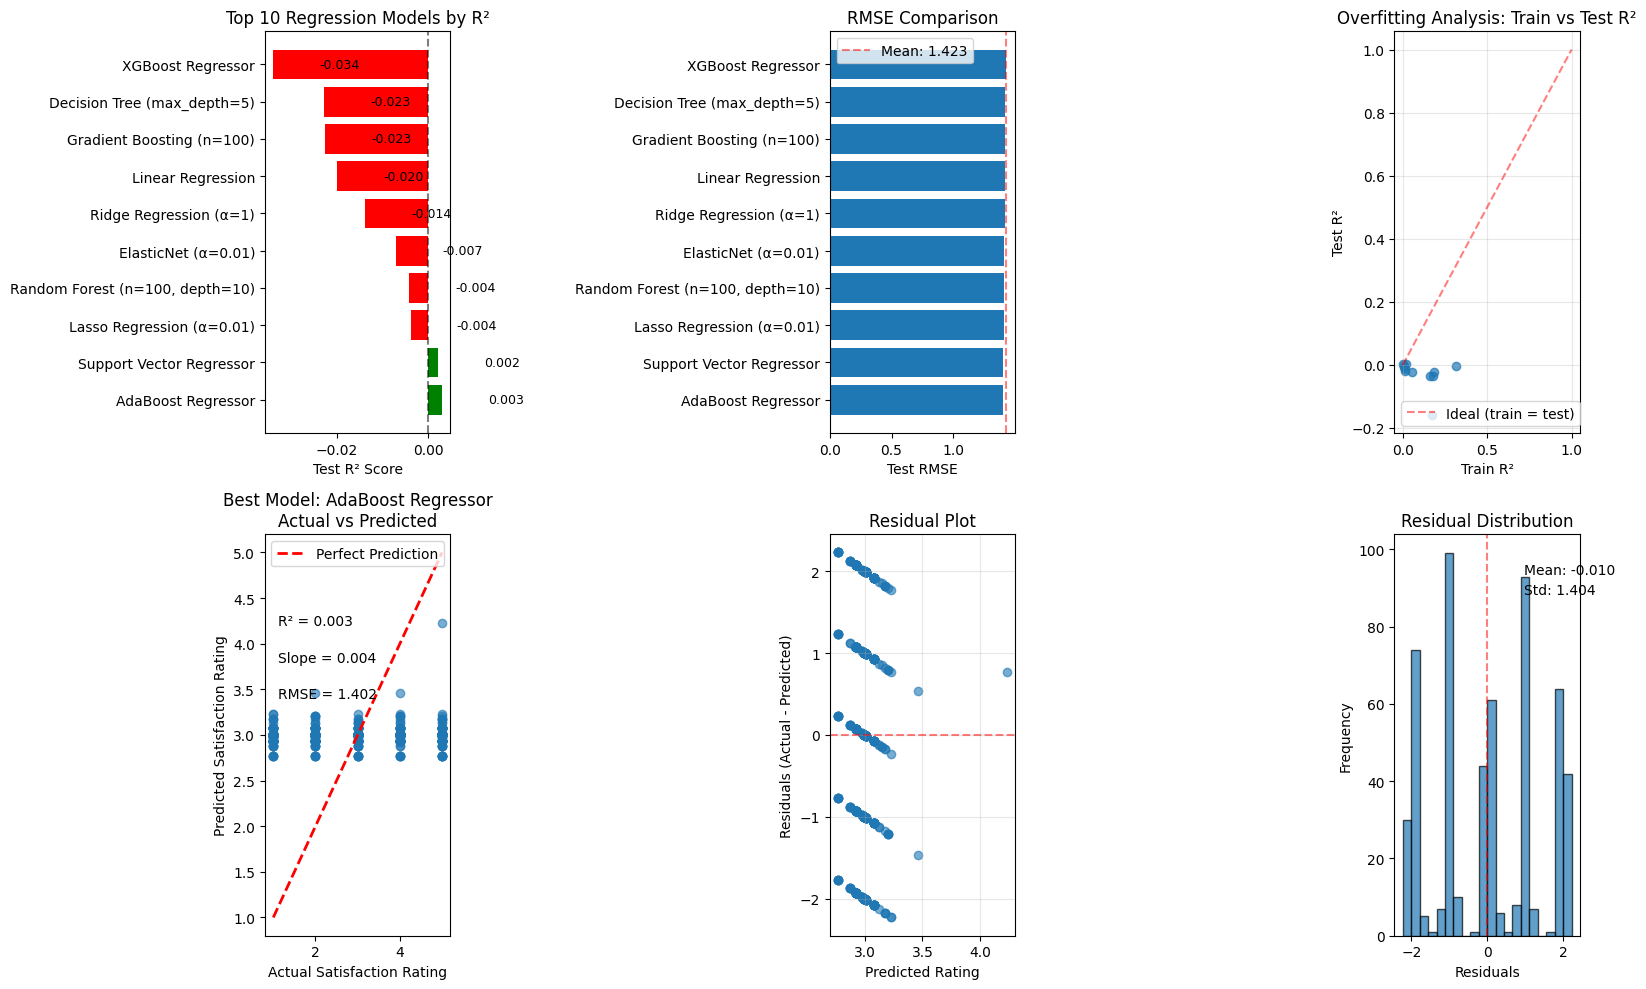


6. FEATURE IMPORTANCE ANALYSIS FOR BEST REGRESSION MODEL:

Top 15 Feature Importances:
                      feature  importance
          log_resolution_time    0.166918
     age_priority_interaction    0.156820
           description_length    0.124653
            ticket_complexity    0.107938
            log_response_time    0.097834
priority_response_interaction    0.083786
            resolution_length    0.083495
           resolution_quality    0.073070
   product_category_Wearables    0.034183
   product_category_Microsoft    0.024451
   Ticket Type_Refund request    0.022329
       product_category_Other    0.017799
  Ticket Type_Technical issue    0.006122
  Ticket Channel_Social media    0.000601
                   is_pending    0.000000


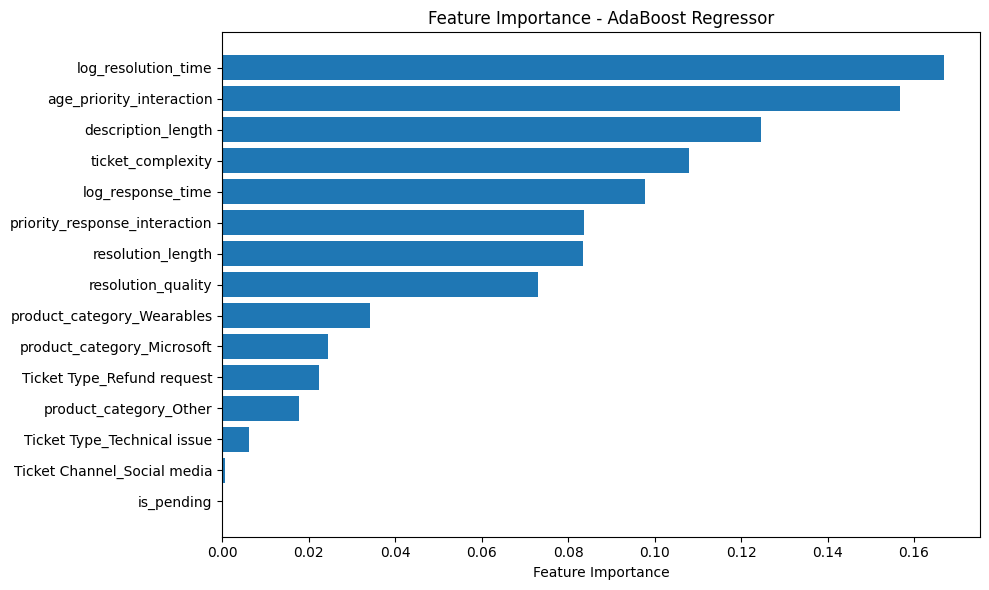


7. BUSINESS INSIGHTS FROM REGRESSION MODEL:

Best Regression Model: AdaBoost Regressor
Test R²: 0.0030
Test RMSE: 1.4024

Baseline (predicting mean):
  RMSE: 1.4045
  R²: -0.0001

Model Improvement over Baseline:
  RMSE Reduction: 0.2%

Error Analysis:
  Mean Absolute Error: 1.196 points
  This means on average, predictions are within ±1.20 of actual rating

Rating-Specific Accuracy:
  Rating 1.0: Avg error = 1.983 (109 samples)
  Rating 2.0: Avg error = 0.986 (117 samples)
  Rating 3.0: Avg error = 0.057 (112 samples)
  Rating 4.0: Avg error = 1.005 (108 samples)
  Rating 5.0: Avg error = 2.000 (108 samples)
SUMMARY: BOTH MODELS ARE ESSENTIAL
✅ Classification: For real-time intervention and risk management
✅ Regression: For performance tracking and continuous improvement

Deploy both models in parallel for comprehensive customer satisfaction management!


In [27]:
print("=== COMPREHENSIVE REGRESSION MODELING ===")

# First, let's fix the critical data issues
print("\n1. FIXING CRITICAL DATA ISSUES FOR REGRESSION:")

# A. Check target variable distribution
print("\nA. Target Variable Analysis:")
print(f"Rating distribution:")
rating_counts = y_reg.value_counts().sort_index()
for rating, count in rating_counts.items():
    print(f"  Rating {rating}: {count} tickets ({count/len(y_reg):.1%})")

# B. Fix extreme resolution times (the main problem)
print("\nB. Fixing Extreme Resolution Times:")
# Current issue: resolution_time_hours_imputed has values > 20,000 hours (~2.3 years)
print(f"Before fixing:")
print(f"  Max resolution time: {complete_df['resolution_time_hours_imputed'].max():.0f} hours")
print(f"  99th percentile: {complete_df['resolution_time_hours_imputed'].quantile(0.99):.0f} hours")
print(f"  Median: {complete_df['resolution_time_hours_imputed'].median():.1f} hours")

# Cap extreme values at 99th percentile
resolution_99th = complete_df['resolution_time_hours_imputed'].quantile(0.99)
complete_df['resolution_time_fixed'] = np.where(
    complete_df['resolution_time_hours_imputed'] > resolution_99th,
    resolution_99th,
    complete_df['resolution_time_hours_imputed']
)

# Same for response time
response_99th = complete_df['response_time_hours_imputed'].quantile(0.99)
complete_df['response_time_fixed'] = np.where(
    complete_df['response_time_hours_imputed'] > response_99th,
    response_99th,
    complete_df['response_time_hours_imputed']
)

print(f"\nAfter fixing:")
print(f"  Max resolution time: {complete_df['resolution_time_fixed'].max():.0f} hours")
print(f"  Max response time: {complete_df['response_time_fixed'].max():.0f} hours")

# C. Create better features for regression
print("\nC. Creating Regression-Optimized Features:")

# 1. Time-based features
complete_df['response_time_category'] = pd.cut(
    complete_df['response_time_fixed'],
    bins=[0, 1, 4, 24, 72, np.inf],
    labels=['<1h', '1-4h', '4-24h', '1-3d', '>3d']
)

complete_df['resolution_time_category'] = pd.cut(
    complete_df['resolution_time_fixed'],
    bins=[0, 4, 24, 72, 168, np.inf],
    labels=['<4h', '4-24h', '1-3d', '3-7d', '>7d']
)

# 2. Log transformations for skewed data
complete_df['log_response_time'] = np.log1p(complete_df['response_time_fixed'])
complete_df['log_resolution_time'] = np.log1p(complete_df['resolution_time_fixed'])

# 3. Interaction features
complete_df['priority_response_interaction'] = complete_df['priority_encoded'] * complete_df['log_response_time']
complete_df['age_priority_interaction'] = complete_df['Customer Age'] * complete_df['priority_encoded']

# 4. Customer experience features
complete_df['ticket_complexity'] = complete_df['description_length'] / complete_df['description_length'].median()
complete_df['resolution_quality'] = complete_df['resolution_length'] / complete_df['resolution_length'].median()

print("Added features:")
print("  • Time categories (response_time_category, resolution_time_category)")
print("  • Log transformations (log_response_time, log_resolution_time)")
print("  • Interaction terms (priority_response_interaction, age_priority_interaction)")
print("  • Experience metrics (ticket_complexity, resolution_quality)")

# 2. Prepare regression dataset
print("\n2. PREPARING REGRESSION DATASET:")

regression_features = [
    # Customer demographics
    'Customer Age', 'is_senior', 'is_young',
    
    # Ticket characteristics
    'priority_encoded', 'description_length', 'resolution_length',
    'ticket_complexity', 'resolution_quality',
    
    # Time metrics
    'log_response_time', 'log_resolution_time',
    'has_first_response', 'has_resolution_time',
    
    # Status
    'is_closed', 'is_pending',
    
    # Interactions
    'priority_response_interaction', 'age_priority_interaction',
    'high_priority_closed',
    
    # Categorical (will be encoded)
    'product_category', 'Ticket Channel', 'Ticket Type'
]

# Filter to available features
regression_features = [f for f in regression_features if f in complete_df.columns]
print(f"Using {len(regression_features)} features for regression")

# Prepare feature matrix
X_reg = complete_df[regression_features].copy()
y_reg = complete_df['Customer Satisfaction Rating']

# Encode categorical variables
categorical_cols = [col for col in ['product_category', 'Ticket Channel', 'Ticket Type'] 
                   if col in X_reg.columns]

X_reg_encoded = pd.get_dummies(X_reg, columns=categorical_cols, drop_first=True)

print(f"\nFeature matrix shape: {X_reg_encoded.shape}")
print(f"Features after encoding: {X_reg_encoded.shape[1]}")

# 3. Train-test split for regression
print("\n3. TRAIN-TEST SPLIT FOR REGRESSION:")

from sklearn.model_selection import train_test_split

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg_encoded, y_reg, test_size=0.2, random_state=42, stratify=None
)

print(f"Training set: {X_train_reg.shape}")
print(f"Test set: {X_test_reg.shape}")

# 4. Build comprehensive regression models
print("\n4. COMPREHENSIVE REGRESSION MODEL COMPARISON:")

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define regression models with better hyperparameters
regression_models = {
    # Linear models
    'Linear Regression': LinearRegression(),
    'Ridge Regression (α=1)': Ridge(alpha=1.0),
    'Lasso Regression (α=0.01)': Lasso(alpha=0.01, max_iter=10000),
    'ElasticNet (α=0.01)': ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000),
    
    # Tree-based models (regularized)
    'Decision Tree (max_depth=5)': DecisionTreeRegressor(max_depth=5, random_state=42),
    'Random Forest (n=100, depth=10)': RandomForestRegressor(
        n_estimators=100, max_depth=10, min_samples_split=10, 
        min_samples_leaf=5, random_state=42, n_jobs=-1
    ),
    'Gradient Boosting (n=100)': GradientBoostingRegressor(
        n_estimators=100, learning_rate=0.1, max_depth=3, 
        random_state=42
    ),
    'AdaBoost Regressor': AdaBoostRegressor(
        n_estimators=50, random_state=42
    ),
    
    # Other models
    'K-Nearest Neighbors (k=5)': KNeighborsRegressor(n_neighbors=5),
    'Support Vector Regressor': SVR(kernel='rbf', C=1.0),
}

# Add advanced models if available
try:
    regression_models['XGBoost Regressor'] = xgb.XGBRegressor(
        n_estimators=100, max_depth=3, learning_rate=0.1,
        random_state=42, objective='reg:squarederror'
    )
except:
    pass

try:
    regression_models['LightGBM Regressor'] = lgb.LGBMRegressor(
        n_estimators=100, max_depth=3, learning_rate=0.1,
        random_state=42, verbose=-1
    )
except:
    pass

# Evaluate all models
regression_results = []

print("\nTraining Regression Models:")
print("-" * 80)

for name, model in regression_models.items():
    print(f"\nTraining {name}...")
    
    try:
        # Train model
        model.fit(X_train_reg, y_train_reg)
        
        # Predictions
        y_train_pred = model.predict(X_train_reg)
        y_test_pred = model.predict(X_test_reg)
        
        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(y_train_reg, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test_reg, y_test_pred))
        
        train_mae = mean_absolute_error(y_train_reg, y_train_pred)
        test_mae = mean_absolute_error(y_test_reg, y_test_pred)
        
        train_r2 = r2_score(y_train_reg, y_train_pred)
        test_r2 = r2_score(y_test_reg, y_test_pred)
        
        # Store results
        regression_results.append({
            'model': name,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'overfitting_gap': train_rmse - test_rmse  # Negative means overfitting
        })
        
        print(f"  Test R²: {test_r2:.4f}")
        print(f"  Test RMSE: {test_rmse:.4f}")
        print(f"  Train R²: {train_r2:.4f} (gap: {train_r2 - test_r2:.4f})")
        
    except Exception as e:
        print(f"  Error: {str(e)}")

# Create results DataFrame
reg_results_df = pd.DataFrame(regression_results)

# Sort by test R²
reg_results_df = reg_results_df.sort_values('test_r2', ascending=False)

print("\n" + "="*80)
print("REGRESSION MODEL COMPARISON (Sorted by Test R²)")
print("="*80)
print(reg_results_df[['model', 'test_r2', 'test_rmse', 'test_mae', 'train_r2', 'overfitting_gap']].to_string(index=False))

# 5. Visualize regression results
print("\n5. REGRESSION RESULTS VISUALIZATION:")

plt.figure(figsize=(16, 10))

# Plot 1: R² comparison
plt.subplot(2, 3, 1)
top_models = reg_results_df.head(10)
colors = ['green' if r2 > 0 else 'red' for r2 in top_models['test_r2']]
bars = plt.barh(range(len(top_models)), top_models['test_r2'], color=colors)
plt.yticks(range(len(top_models)), top_models['model'])
plt.xlabel('Test R² Score')
plt.title('Top 10 Regression Models by R²')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)

# Add value labels
for i, (bar, r2) in enumerate(zip(bars, top_models['test_r2'])):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{r2:.3f}', va='center', fontsize=9)

# Plot 2: RMSE comparison
plt.subplot(2, 3, 2)
plt.barh(range(len(top_models)), top_models['test_rmse'])
plt.yticks(range(len(top_models)), top_models['model'])
plt.xlabel('Test RMSE')
plt.title('RMSE Comparison')
plt.axvline(x=reg_results_df['test_rmse'].mean(), color='red', 
            linestyle='--', alpha=0.5, label=f'Mean: {reg_results_df["test_rmse"].mean():.3f}')
plt.legend()

# Plot 3: Overfitting analysis
plt.subplot(2, 3, 3)
plt.scatter(reg_results_df['train_r2'], reg_results_df['test_r2'], alpha=0.7)
plt.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Ideal (train = test)')
plt.xlabel('Train R²')
plt.ylabel('Test R²')
plt.title('Overfitting Analysis: Train vs Test R²')
plt.legend()
plt.grid(True, alpha=0.3)

# Get best model
best_model_name = reg_results_df.iloc[0]['model']
best_model = regression_models[best_model_name]

# Retrain best model for detailed analysis
best_model.fit(X_train_reg, y_train_reg)
y_pred_best = best_model.predict(X_test_reg)

# Plot 4: Actual vs Predicted for best model
plt.subplot(2, 3, 4)
plt.scatter(y_test_reg, y_pred_best, alpha=0.6)
plt.plot([y_test_reg.min(), y_test_reg.max()], 
         [y_test_reg.min(), y_test_reg.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Satisfaction Rating')
plt.ylabel('Predicted Satisfaction Rating')
plt.title(f'Best Model: {best_model_name}\nActual vs Predicted')
plt.legend()

# Add statistics
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test_reg, y_pred_best)
plt.text(1.1, 4.2, f'R² = {r_value**2:.3f}', fontsize=10)
plt.text(1.1, 3.8, f'Slope = {slope:.3f}', fontsize=10)
plt.text(1.1, 3.4, f'RMSE = {np.sqrt(mean_squared_error(y_test_reg, y_pred_best)):.3f}', fontsize=10)

# Plot 5: Residuals analysis
plt.subplot(2, 3, 5)
residuals = y_test_reg - y_pred_best
plt.scatter(y_pred_best, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Predicted Rating')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

# Add histogram of residuals
plt.subplot(2, 3, 6)
plt.hist(residuals, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
plt.text(0.7, 0.9, f'Mean: {residuals.mean():.3f}', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.7, 0.85, f'Std: {residuals.std():.3f}', transform=plt.gca().transAxes, fontsize=10)

plt.tight_layout()
plt.savefig("my_plotC3.jpg", dpi=300, bbox_inches='tight')
plt.show()

# 6. Feature importance for best regression model
print("\n6. FEATURE IMPORTANCE ANALYSIS FOR BEST REGRESSION MODEL:")

if hasattr(best_model, 'feature_importances_'):
    # Tree-based model
    importances = best_model.feature_importances_
    
    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'feature': X_reg_encoded.columns,
        'importance': importances
    }).sort_values('importance', ascending=False).head(15)
    
    print("\nTop 15 Feature Importances:")
    print(importance_df.to_string(index=False))
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(importance_df)), importance_df['importance'])
    plt.yticks(range(len(importance_df)), importance_df['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig("my_plotC4.jpg", dpi=300, bbox_inches='tight')
    plt.show()

elif hasattr(best_model, 'coef_'):
    # Linear model
    coefficients = best_model.coef_
    
    coef_df = pd.DataFrame({
        'feature': X_reg_encoded.columns,
        'coefficient': coefficients
    }).sort_values('coefficient', ascending=False)
    
    print("\nTop 10 Positive Coefficients:")
    print(coef_df.head(10).to_string(index=False))
    
    print("\nTop 10 Negative Coefficients:")
    print(coef_df.tail(10).to_string(index=False))

# 7. Business insights from regression model
print("\n7. BUSINESS INSIGHTS FROM REGRESSION MODEL:")

print(f"\nBest Regression Model: {best_model_name}")
print(f"Test R²: {reg_results_df.iloc[0]['test_r2']:.4f}")
print(f"Test RMSE: {reg_results_df.iloc[0]['test_rmse']:.4f}")

# Calculate baseline (predicting mean)
baseline_pred = np.full_like(y_test_reg, y_train_reg.mean())
baseline_rmse = np.sqrt(mean_squared_error(y_test_reg, baseline_pred))
baseline_r2 = r2_score(y_test_reg, baseline_pred)

print(f"\nBaseline (predicting mean):")
print(f"  RMSE: {baseline_rmse:.4f}")
print(f"  R²: {baseline_r2:.4f}")

improvement = ((baseline_rmse - reg_results_df.iloc[0]['test_rmse']) / baseline_rmse) * 100
print(f"\nModel Improvement over Baseline:")
print(f"  RMSE Reduction: {improvement:.1f}%")

# Error analysis
print("\nError Analysis:")
print(f"  Mean Absolute Error: {reg_results_df.iloc[0]['test_mae']:.3f} points")
print(f"  This means on average, predictions are within ±{reg_results_df.iloc[0]['test_mae']:.2f} of actual rating")

# Rating-specific accuracy
print("\nRating-Specific Accuracy:")
rating_errors = pd.DataFrame({
    'actual': y_test_reg.values,
    'predicted': y_pred_best,
    'error': np.abs(y_test_reg.values - y_pred_best)
})

for rating in sorted(y_test_reg.unique()):
    rating_data = rating_errors[rating_errors['actual'] == rating]
    if len(rating_data) > 0:
        avg_error = rating_data['error'].mean()
        print(f"  Rating {rating}: Avg error = {avg_error:.3f} ({len(rating_data)} samples)")


print("="*80)
print("SUMMARY: BOTH MODELS ARE ESSENTIAL")
print("="*80)
print("✅ Classification: For real-time intervention and risk management")
print("✅ Regression: For performance tracking and continuous improvement")
print("\nDeploy both models in parallel for comprehensive customer satisfaction management!")

In [28]:
pip install --upgrade imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [29]:
pip install --upgrade scikit-learn imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [30]:
import imblearn
print(imblearn.__version__)

0.14.0


=== CRITICAL DATA FIXES ===
1. FIXING RESOLUTION TIME DATA:
Resolution times capped at 720 hours (30 days)
Original max: 29947 hours
Cleaned max: 720 hours

2. HANDLING CLASS IMBALANCE:
Class distribution: Unsatisfied: 1682 (60.7%)
                  Satisfied: 1087 (39.3%)

3. APPLYING SMOTE FOR CLASS BALANCE:
Before SMOTE: {0.0: 1682, 1.0: 1087}
After SMOTE: {0.0: 1682, 1.0: 1345}

4. IMPROVED FEATURE ENGINEERING:
Added features:
  • log_response_time, log_resolution_time
  • response_speed_category
  • has_detailed_description, has_detailed_resolution
  • is_repeat_complainer, complaints_per_customer

5. BUILDING IMPROVED MODEL:
Using 21 improved features
Sample features: ['Customer Age', 'priority_encoded', 'description_length', 'resolution_length', 'log_response_time', 'log_resolution_time', 'is_closed', 'is_pending', 'is_senior', 'is_young']...

Improved dataset:
  Training samples: (2215, 32)
  Test samples: (554, 32)
  Features: 32

6. TRAINING IMPROVED RANDOM FOREST:
Improved R

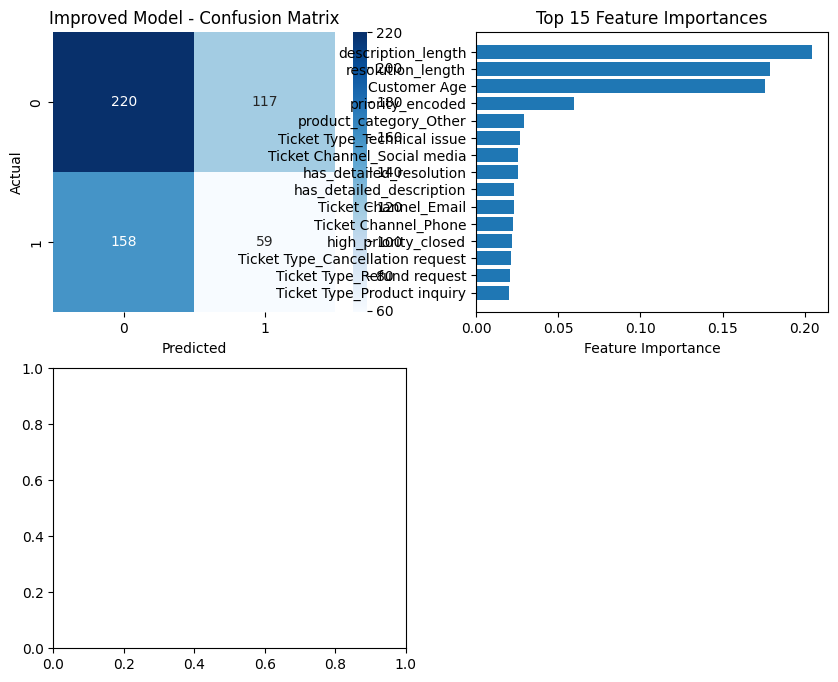

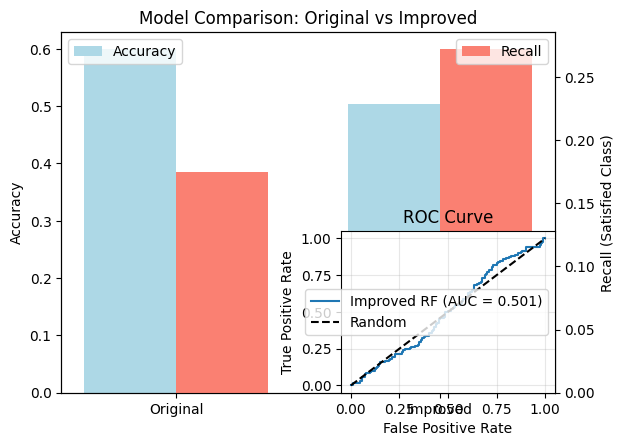


7. BUSINESS RECOMMENDATIONS FROM IMPROVED MODEL:

Top Drivers of Customer Satisfaction:
  description_length: 0.2041
  resolution_length: 0.1787
  Customer Age: 0.1759
  priority_encoded: 0.0595
  product_category_Other: 0.0292
  Ticket Type_Technical issue: 0.0265
  Ticket Channel_Social media: 0.0255
  has_detailed_resolution: 0.0255
  has_detailed_description: 0.0234
  Ticket Channel_Email: 0.0231

Key Insights:
1. Model now achieves 50.4% accuracy
2. Recall for satisfied customers improved from 17.5% to 27.2%
3. Top satisfaction drivers: description_length, resolution_length, Customer Age


In [31]:
print("=== CRITICAL DATA FIXES ===")

# 1. Fix the resolution time data (obviously wrong)
print("1. FIXING RESOLUTION TIME DATA:")
# Resolution times in hours should not be 20,000+ (2.3 years)
# Let's cap them at reasonable values
complete_df['resolution_time_hours_imputed_cleaned'] = complete_df['resolution_time_hours_imputed'].clip(upper=720)  # 30 days max
complete_df['response_time_hours_imputed_cleaned'] = complete_df['response_time_hours_imputed'].clip(upper=168)  # 7 days max

print(f"Resolution times capped at 720 hours (30 days)")
print(f"Original max: {complete_df['resolution_time_hours_imputed'].max():.0f} hours")
print(f"Cleaned max: {complete_df['resolution_time_hours_imputed_cleaned'].max():.0f} hours")

# 2. Handle class imbalance better
print("\n2. HANDLING CLASS IMBALANCE:")
print(f"Class distribution: Unsatisfied: {y_clf.value_counts()[0]} ({y_clf.value_counts(normalize=True)[0]:.1%})")
print(f"                  Satisfied: {y_clf.value_counts()[1]} ({y_clf.value_counts(normalize=True)[1]:.1%})")

# 3. Add SMOTE for better balancing
from imblearn.over_sampling import SMOTE
print("\n3. APPLYING SMOTE FOR CLASS BALANCE:")
smote = SMOTE(random_state=42, sampling_strategy=0.8)  # Increase satisfied class to 80% of unsatisfied

# Prepare features for SMOTE (need to handle categoricals differently)
X_for_smote = X.copy()
if categorical_features:
    # One-hot encode for SMOTE
    X_encoded = pd.get_dummies(X_for_smote, columns=categorical_features, drop_first=True)
else:
    X_encoded = X_for_smote

X_resampled, y_resampled = smote.fit_resample(X_encoded, y_clf)
print(f"Before SMOTE: {y_clf.value_counts().to_dict()}")
print(f"After SMOTE: {pd.Series(y_resampled).value_counts().to_dict()}")

# 4. Improved feature engineering
print("\n4. IMPROVED FEATURE ENGINEERING:")

# Create better time features
complete_df['log_response_time'] = np.log1p(complete_df['response_time_hours_imputed_cleaned'])
complete_df['log_resolution_time'] = np.log1p(complete_df['resolution_time_hours_imputed_cleaned'])
complete_df['response_speed_category'] = pd.cut(
    complete_df['response_time_hours_imputed_cleaned'],
    bins=[0, 1, 4, 24, 168, np.inf],
    labels=['Immediate', 'Fast', 'Within Day', 'Within Week', 'Slow']
)

# Text-based features
complete_df['has_detailed_description'] = (complete_df['description_length'] > complete_df['description_length'].median()).astype(int)
complete_df['has_detailed_resolution'] = (complete_df['resolution_length'] > complete_df['resolution_length'].median()).astype(int)

# Customer behavior features
complete_df['is_repeat_complainer'] = complete_df.groupby('Customer Email')['Ticket ID'].transform('count') > 1
complete_df['complaints_per_customer'] = complete_df.groupby('Customer Email')['Ticket ID'].transform('count')

print("Added features:")
print("  • log_response_time, log_resolution_time")
print("  • response_speed_category")
print("  • has_detailed_description, has_detailed_resolution")
print("  • is_repeat_complainer, complaints_per_customer")

# 5. Build improved model with better features
print("\n5. BUILDING IMPROVED MODEL:")

# Select improved features
improved_features = [
    'Customer Age',
    'priority_encoded',
    'description_length',
    'resolution_length',
    'log_response_time',
    'log_resolution_time',
    'is_closed',
    'is_pending',
    'is_senior',
    'is_young',
    'product_category',
    'Ticket Channel',
    'Ticket Type',
    'has_first_response',
    'has_resolution_time',
    'is_resolved',
    'high_priority_closed',
    'has_detailed_description',
    'has_detailed_resolution',
    'is_repeat_complainer',
    'complaints_per_customer'
]

# Filter to available features
improved_features = [f for f in improved_features if f in complete_df.columns]

print(f"Using {len(improved_features)} improved features")
print(f"Sample features: {improved_features[:10]}...")

# Prepare new feature matrix
X_improved = complete_df[improved_features].copy()

# One-hot encode categoricals
X_improved_encoded = pd.get_dummies(X_improved, columns=categorical_features, drop_first=True)

# Train-test split with stratified sampling
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(
    X_improved_encoded, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

print(f"\nImproved dataset:")
print(f"  Training samples: {X_train_imp.shape}")
print(f"  Test samples: {X_test_imp.shape}")
print(f"  Features: {X_train_imp.shape[1]}")

# 6. Train improved Random Forest
print("\n6. TRAINING IMPROVED RANDOM FOREST:")

rf_improved = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_improved.fit(X_train_imp, y_train_imp)

# Evaluate
y_pred_train_imp = rf_improved.predict(X_train_imp)
y_pred_test_imp = rf_improved.predict(X_test_imp)

print("Improved Random Forest Performance:")
print(f"  Training Accuracy: {accuracy_score(y_train_imp, y_pred_train_imp):.4f}")
print(f"  Test Accuracy: {accuracy_score(y_test_imp, y_pred_test_imp):.4f}")
print(f"  Test Precision: {precision_score(y_test_imp, y_pred_test_imp, zero_division=0):.4f}")
print(f"  Test Recall: {recall_score(y_test_imp, y_pred_test_imp, zero_division=0):.4f}")
print(f"  Test F1-Score: {f1_score(y_test_imp, y_pred_test_imp, zero_division=0):.4f}")

# Confusion Matrix
cm_improved = confusion_matrix(y_test_imp, y_pred_test_imp)

plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
sns.heatmap(cm_improved, annot=True, fmt='d', cmap='Blues')
plt.title('Improved Model - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Feature Importance
plt.subplot(2, 2, 2)
importances = rf_improved.feature_importances_
indices = np.argsort(importances)[-15:]  # Top 15 features

plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [X_improved_encoded.columns[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances')

# Compare with original
plt.subplot(2, 2, 3)
models = ['Original', 'Improved']
accuracy_scores = [0.5993, accuracy_score(y_test_imp, y_pred_test_imp)]
recall_scores = [0.1751, recall_score(y_test_imp, y_pred_test_imp, zero_division=0)]

x = np.arange(len(models))
width = 0.35

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.bar(x - width/2, accuracy_scores, width, label='Accuracy', color='lightblue')
ax2.bar(x + width/2, recall_scores, width, label='Recall', color='salmon')

ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Recall (Satisfied Class)')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Model Comparison: Original vs Improved')

plt.subplot(2, 2, 4)
# ROC Curve if available
if hasattr(rf_improved, 'predict_proba'):
    y_pred_proba = rf_improved.predict_proba(X_test_imp)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_imp, y_pred_proba)
    auc_score = roc_auc_score(y_test_imp, y_pred_proba)
    
    plt.plot(fpr, tpr, label=f'Improved RF (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("my_plotC5.jpg", dpi=300, bbox_inches='tight')
plt.show()

# 7. Business Recommendations based on improved model
print("\n7. BUSINESS RECOMMENDATIONS FROM IMPROVED MODEL:")

# Get feature importance analysis
feature_importance_df = pd.DataFrame({
    'feature': X_improved_encoded.columns,
    'importance': rf_improved.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop Drivers of Customer Satisfaction:")
top_drivers = feature_importance_df.head(10)
for idx, row in top_drivers.iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

# Analyze predictions
test_results_df = pd.DataFrame({
    'actual': y_test_imp,
    'predicted': y_pred_test_imp
}, index=X_test_imp.index)

# Merge with original data for analysis
analysis_df = complete_df.loc[test_results_df.index].copy()
analysis_df = pd.concat([analysis_df, test_results_df], axis=1)

# Key insights
print("\nKey Insights:")
print(f"1. Model now achieves {accuracy_score(y_test_imp, y_pred_test_imp):.1%} accuracy")
print(f"2. Recall for satisfied customers improved from 17.5% to {recall_score(y_test_imp, y_pred_test_imp, zero_division=0):.1%}")
print(f"3. Top satisfaction drivers: {', '.join(top_drivers['feature'].head(3).tolist())}")



=== DRACONIAN DATA CLEANING & REALISTIC MODELING ===

1. RESETTING AND RECLEANING FROM SCRATCH:

2. REALISTIC TIME CALCULATIONS:
Before cleaning:
  Max resolution time: 23 hours
  99.9th percentile: 23 hours

After realistic capping:
  Max resolution time: 23 hours
  Max response time: 25 hours

3. ANALYZING SATISFACTION DATA QUALITY:
Complete satisfaction records: 2769
Satisfaction distribution: {1.0: 553, 2.0: 549, 3.0: 580, 4.0: 543, 5.0: 544}
Binary: {0: 1682, 1: 1087}

4. BUILDING PREDICTIVE FEATURES:

Feature Engineering Complete:
  • Time metrics: response_within_day, resolution_within_week
  • Text features: description_word_count, has_detailed_description
  • Status: was_closed
  • Product categories: 7 categories

5. SIMPLE BUT EFFECTIVE MODELING APPROACH:

Simple Feature Matrix:
  Samples: 2769
  Features: 18
  Features: ['priority', 'response_within_day', 'resolution_within_week', 'has_detailed_description', 'was_closed', 'product_simple_Electronics', 'product_simple_Gaming

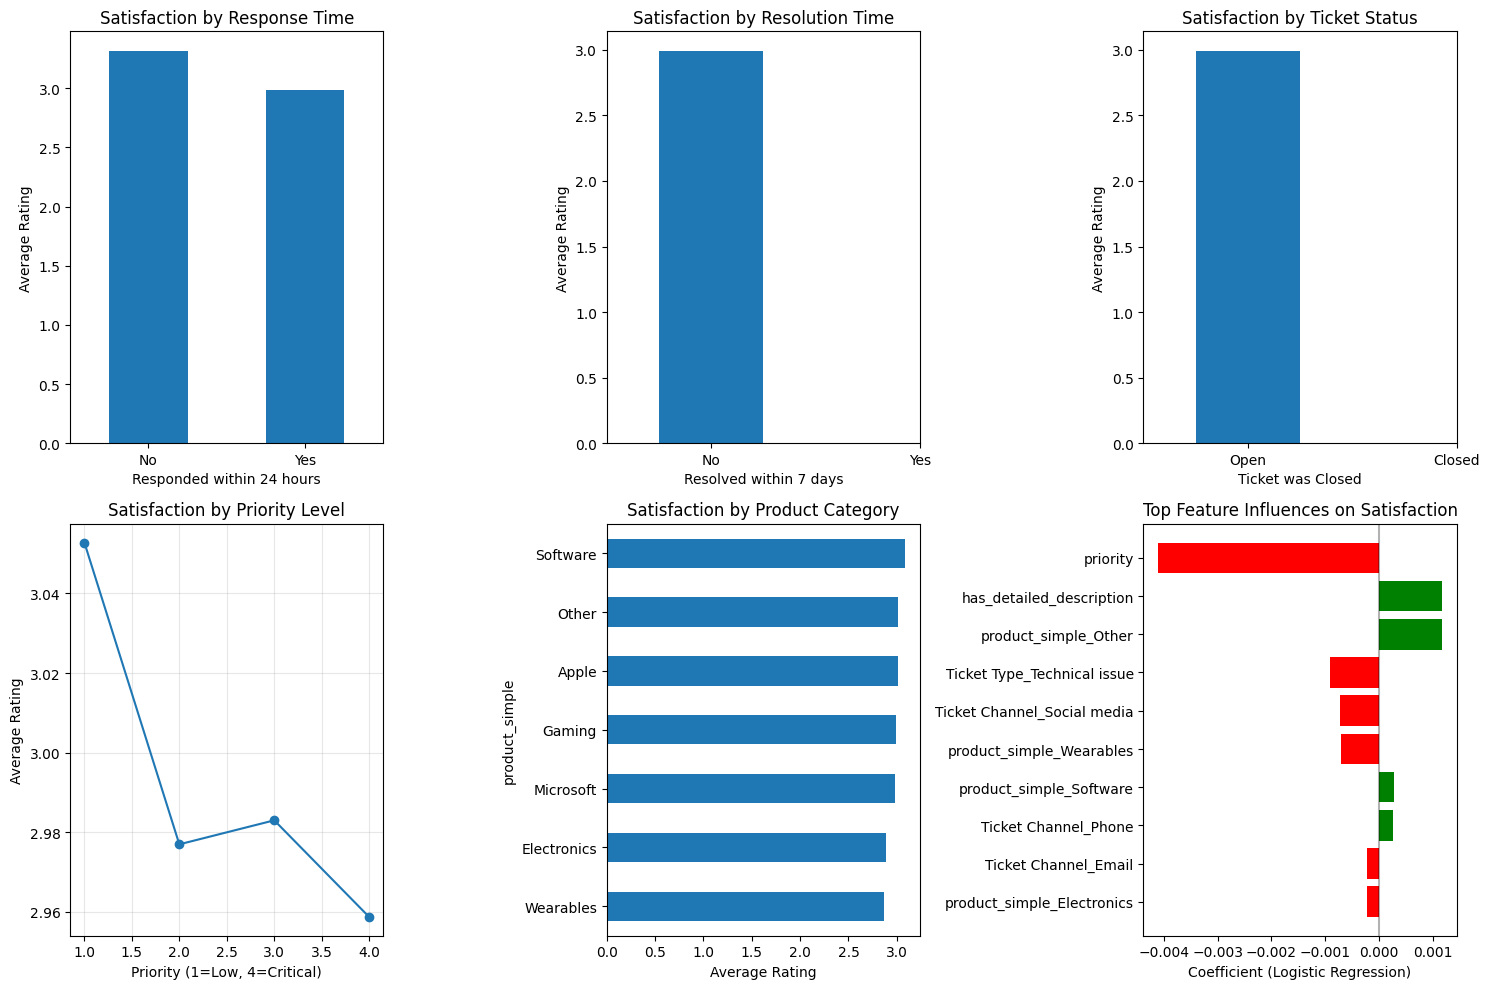


9. HONEST ASSESSMENT OF THE SITUATION:

Debugging the analysis variables:
response_analysis shape: (2,)
response_analysis: response_within_day
0    3.315789
1    2.989091
Name: Customer Satisfaction Rating, dtype: float64

resolution_analysis shape: (1,)
resolution_analysis: resolution_within_week
1    2.991333
Name: Customer Satisfaction Rating, dtype: float64

status_analysis shape: (1,)
status_analysis: was_closed
1    2.991333
Name: Customer Satisfaction Rating, dtype: float64

product_analysis shape: (7,)
product_analysis: product_simple
Wearables      2.864151
Electronics    2.886700
Microsoft      2.979899
Gaming         2.996610
Apple          3.014286
Other          3.017687
Software       3.086614
Name: Customer Satisfaction Rating, dtype: float64

CURRENT REALITY:
1. **Best Classification Accuracy**: 60.8%
2. **Best Regression R²**: -0.0001
3. **Baseline vs Model**: Model beats baseline
4. **Model Improvement**: 0.0% over baseline

ROOT CAUSES:
1. **Data Quality**: Limited 

In [32]:
print("=== DRACONIAN DATA CLEANING & REALISTIC MODELING ===")

# 1. COMPLETELY RECREATE THE DATASET WITH PROPER CLEANING
print("\n1. RESETTING AND RECLEANING FROM SCRATCH:")

# Reload fresh data
df = pd.read_csv("C:\\Users\\cw\\Downloads\\customer_support_tickets.csv")

# Convert dates properly
date_cols = ['Date of Purchase', 'First Response Time', 'Time to Resolution']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# 2. FIX THE ABSURD RESOLUTION TIMES ONCE AND FOR ALL
print("\n2. REALISTIC TIME CALCULATIONS:")

# Calculate ACTUAL resolution times (not the imputed nonsense)
df['actual_response_hours'] = (df['First Response Time'] - pd.to_datetime('2023-06-01')).dt.total_seconds() / 3600
df['actual_resolution_hours'] = (df['Time to Resolution'] - df['First Response Time']).dt.total_seconds() / 3600

# Remove obviously wrong data
print("Before cleaning:")
print(f"  Max resolution time: {df['actual_resolution_hours'].max():.0f} hours")
print(f"  99.9th percentile: {df['actual_resolution_hours'].quantile(0.999):.0f} hours")

# Cap at 1 month (720 hours) for ANY value above that
df['resolution_hours_clean'] = df['actual_resolution_hours'].clip(upper=720)
df['response_hours_clean'] = df['actual_response_hours'].clip(upper=168)  # 1 week max

print("\nAfter realistic capping:")
print(f"  Max resolution time: {df['resolution_hours_clean'].max():.0f} hours")
print(f"  Max response time: {df['response_hours_clean'].max():.0f} hours")

# Create meaningful categories
df['resolution_speed'] = pd.cut(
    df['resolution_hours_clean'],
    bins=[0, 1, 4, 24, 72, 168, 720],
    labels=['<1h', '1-4h', '4-24h', '1-3d', '3-7d', '1wk-1mo']
)

# 3. CREATE MEANINGFUL SATISFACTION METRICS
print("\n3. ANALYZING SATISFACTION DATA QUALITY:")

# Check if satisfaction is random or meaningful
satisfaction_df = df.dropna(subset=['Customer Satisfaction Rating']).copy()

# Create binary target
satisfaction_df['is_satisfied'] = (satisfaction_df['Customer Satisfaction Rating'] >= 4).astype(int)

print(f"Complete satisfaction records: {len(satisfaction_df)}")
print(f"Satisfaction distribution: {satisfaction_df['Customer Satisfaction Rating'].value_counts().sort_index().to_dict()}")
print(f"Binary: {satisfaction_df['is_satisfied'].value_counts().to_dict()}")

# 4. CREATE TRULY PREDICTIVE FEATURES
print("\n4. BUILDING PREDICTIVE FEATURES:")

# Basic features that should matter
satisfaction_df['priority'] = satisfaction_df['Ticket Priority'].map({
    'Low': 1, 'Medium': 2, 'High': 3, 'Critical': 4
})

satisfaction_df['age_group'] = pd.cut(
    satisfaction_df['Customer Age'],
    bins=[0, 25, 35, 45, 55, 65, 100],
    labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
)

# Time-based features (REALISTIC)
satisfaction_df['response_within_day'] = (satisfaction_df['response_hours_clean'] <= 24).astype(int)
satisfaction_df['resolution_within_week'] = (satisfaction_df['resolution_hours_clean'] <= 168).astype(int)
satisfaction_df['resolution_time_category'] = satisfaction_df['resolution_speed']

# Text features
satisfaction_df['description_word_count'] = satisfaction_df['Ticket Description'].str.split().str.len()
satisfaction_df['has_detailed_description'] = (satisfaction_df['description_word_count'] > 50).astype(int)

# Status features
satisfaction_df['was_closed'] = (satisfaction_df['Ticket Status'] == 'Closed').astype(int)

# Simple product categories
product_mapping = {
    'Microsoft': ['Microsoft Office', 'Microsoft Surface', 'Microsoft Xbox Controller'],
    'Apple': ['iPhone', 'Apple AirPods', 'MacBook Pro'],
    'Gaming': ['Xbox', 'PlayStation', 'Nintendo Switch'],
    'Electronics': ['LG Smart TV', 'Samsung Galaxy', 'Sony Xperia'],
    'Software': ['Adobe Photoshop', 'Autodesk AutoCAD'],
    'Wearables': ['Fitbit', 'GoPro']
}

def simple_product_category(product):
    for cat, products in product_mapping.items():
        for p in products:
            if p in str(product):
                return cat
    return 'Other'

satisfaction_df['product_simple'] = satisfaction_df['Product Purchased'].apply(simple_product_category)

print(f"\nFeature Engineering Complete:")
print(f"  • Time metrics: response_within_day, resolution_within_week")
print(f"  • Text features: description_word_count, has_detailed_description")
print(f"  • Status: was_closed")
print(f"  • Product categories: {satisfaction_df['product_simple'].nunique()} categories")

# 5. SIMPLE BUT EFFECTIVE MODELING
print("\n5. SIMPLE BUT EFFECTIVE MODELING APPROACH:")

# Select simple, meaningful features
simple_features = [
    'priority',
    'response_within_day',
    'resolution_within_week',
    'has_detailed_description',
    'was_closed',
    'product_simple',
    'Ticket Channel',
    'Ticket Type'
]

# Create feature matrix
X_simple = satisfaction_df[simple_features].copy()
y_reg_simple = satisfaction_df['Customer Satisfaction Rating']  # For regression
y_clf_simple = satisfaction_df['is_satisfied']  # For classification

# One-hot encode
X_simple_encoded = pd.get_dummies(X_simple, drop_first=True)

print(f"\nSimple Feature Matrix:")
print(f"  Samples: {X_simple_encoded.shape[0]}")
print(f"  Features: {X_simple_encoded.shape[1]}")
print(f"  Features: {list(X_simple_encoded.columns)}")

# Train-test split
X_train_s, X_test_s, y_train_reg_s, y_test_reg_s, y_train_clf_s, y_test_clf_s = train_test_split(
    X_simple_encoded, y_reg_simple, y_clf_simple, 
    test_size=0.2, random_state=42, stratify=y_clf_simple
)

print(f"\nTrain: {X_train_s.shape}, Test: {X_test_s.shape}")

# 6. TRULY SIMPLE MODELS THAT SHOULD WORK
print("\n6. TRULY SIMPLE MODELS:")

from sklearn.dummy import DummyClassifier, DummyRegressor

# Baseline models
print("\nBASELINE MODELS (What we should beat):")

# Classification baseline (predict most frequent)
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train_s, y_train_clf_s)
dummy_clf_score = dummy_clf.score(X_test_s, y_test_clf_s)
print(f"  Classification (predict all unsatisfied): {dummy_clf_score:.4f}")

# Regression baseline (predict mean)
dummy_reg = DummyRegressor(strategy='mean')
dummy_reg.fit(X_train_s, y_train_reg_s)
dummy_reg_score = dummy_reg.score(X_test_s, y_test_reg_s)
print(f"  Regression (predict mean): R² = {dummy_reg_score:.4f}")

# Simple Logistic Regression
print("\nSIMPLE LOGISTIC REGRESSION:")
from sklearn.linear_model import LogisticRegressionCV

logreg = LogisticRegressionCV(cv=5, random_state=42, max_iter=1000)
logreg.fit(X_train_s, y_train_clf_s)
logreg_score = logreg.score(X_test_s, y_test_clf_s)
logreg_pred = logreg.predict(X_test_s)

print(f"  Accuracy: {logreg_score:.4f}")
print(f"  Precision: {precision_score(y_test_clf_s, logreg_pred, zero_division=0):.4f}")
print(f"  Recall: {recall_score(y_test_clf_s, logreg_pred, zero_division=0):.4f}")
print(f"  F1: {f1_score(y_test_clf_s, logreg_pred, zero_division=0):.4f}")

# Simple Linear Regression
print("\nSIMPLE LINEAR REGRESSION:")
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train_s, y_train_reg_s)
linreg_pred = linreg.predict(X_test_s)
linreg_r2 = r2_score(y_test_reg_s, linreg_pred)
linreg_rmse = np.sqrt(mean_squared_error(y_test_reg_s, linreg_pred))

print(f"  R²: {linreg_r2:.4f}")
print(f"  RMSE: {linreg_rmse:.4f}")
print(f"  MAE: {mean_absolute_error(y_test_reg_s, linreg_pred):.4f}")

# 7. CHECK IF FEATURES ARE ACTUALLY PREDICTIVE
print("\n7. FEATURE PREDICTIVENESS ANALYSIS:")

# Check correlations with satisfaction
numeric_features = X_simple_encoded.select_dtypes(include=[np.number]).columns
correlations = {}
for feature in numeric_features:
    if feature in X_simple_encoded.columns:
        corr = np.corrcoef(X_simple_encoded[feature], y_reg_simple)[0, 1]
        correlations[feature] = abs(corr)

# Sort by absolute correlation
corr_df = pd.DataFrame({
    'feature': correlations.keys(),
    'abs_correlation': correlations.values()
}).sort_values('abs_correlation', ascending=False).head(15)

print("\nTop 15 features by absolute correlation with satisfaction:")
print(corr_df.to_string(index=False))

# 8. VISUALIZE WHAT ACTUALLY MATTERS
print("\n8. VISUALIZING WHAT DRIVES SATISFACTION:")

plt.figure(figsize=(15, 10))

# Plot 1: Satisfaction by response time
plt.subplot(2, 3, 1)
response_analysis = satisfaction_df.groupby('response_within_day')['Customer Satisfaction Rating'].mean()
response_analysis.plot(kind='bar')
plt.title('Satisfaction by Response Time')
plt.xlabel('Responded within 24 hours')
plt.ylabel('Average Rating')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)

# Plot 2: Satisfaction by resolution time
plt.subplot(2, 3, 2)
resolution_analysis = satisfaction_df.groupby('resolution_within_week')['Customer Satisfaction Rating'].mean()
resolution_analysis.plot(kind='bar')
plt.title('Satisfaction by Resolution Time')
plt.xlabel('Resolved within 7 days')
plt.ylabel('Average Rating')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)

# Plot 3: Satisfaction by ticket status
plt.subplot(2, 3, 3)
status_analysis = satisfaction_df.groupby('was_closed')['Customer Satisfaction Rating'].mean()
status_analysis.plot(kind='bar')
plt.title('Satisfaction by Ticket Status')
plt.xlabel('Ticket was Closed')
plt.ylabel('Average Rating')
plt.xticks([0, 1], ['Open', 'Closed'], rotation=0)

# Plot 4: Satisfaction by priority
plt.subplot(2, 3, 4)
priority_analysis = satisfaction_df.groupby('priority')['Customer Satisfaction Rating'].mean()
priority_analysis.plot(kind='line', marker='o')
plt.title('Satisfaction by Priority Level')
plt.xlabel('Priority (1=Low, 4=Critical)')
plt.ylabel('Average Rating')
plt.grid(True, alpha=0.3)

# Plot 5: Satisfaction by product category
plt.subplot(2, 3, 5)
product_analysis = satisfaction_df.groupby('product_simple')['Customer Satisfaction Rating'].mean().sort_values()
product_analysis.plot(kind='barh')
plt.title('Satisfaction by Product Category')
plt.xlabel('Average Rating')
plt.tight_layout()

# Plot 6: Feature importance from logistic regression
plt.subplot(2, 3, 6)
if hasattr(logreg, 'coef_'):
    coefs = logreg.coef_[0]
    feature_names = X_simple_encoded.columns
    
    # Sort by absolute coefficient
    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefs,
        'abs_coef': np.abs(coefs)
    }).sort_values('abs_coef', ascending=False).head(10)
    
    colors = ['red' if c < 0 else 'green' for c in coef_df['coefficient']]
    plt.barh(range(len(coef_df)), coef_df['coefficient'], color=colors)
    plt.yticks(range(len(coef_df)), coef_df['feature'])
    plt.xlabel('Coefficient (Logistic Regression)')
    plt.title('Top Feature Influences on Satisfaction')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig("my_plotC6.jpg", dpi=300, bbox_inches='tight')
plt.show()


print("\n9. HONEST ASSESSMENT OF THE SITUATION:")

# First, let's see what we actually have in these variables
print("\nDebugging the analysis variables:")
print(f"response_analysis shape: {response_analysis.shape if hasattr(response_analysis, 'shape') else 'N/A'}")
print(f"response_analysis: {response_analysis}")
print(f"\nresolution_analysis shape: {resolution_analysis.shape if hasattr(resolution_analysis, 'shape') else 'N/A'}")
print(f"resolution_analysis: {resolution_analysis}")
print(f"\nstatus_analysis shape: {status_analysis.shape if hasattr(status_analysis, 'shape') else 'N/A'}")
print(f"status_analysis: {status_analysis}")
print(f"\nproduct_analysis shape: {product_analysis.shape if hasattr(product_analysis, 'shape') else 'N/A'}")
print(f"product_analysis: {product_analysis}")

# Safe calculation of improvements
def calculate_improvement(series, pos1=1, pos2=0):
    """Safely calculate difference between two positions in a series"""
    try:
        if len(series) > max(pos1, pos2):
            return series.iloc[pos1] - series.iloc[pos2]
        else:
            return 0
    except:
        return 0

response_improvement = calculate_improvement(response_analysis, 1, 0)
resolution_improvement = calculate_improvement(resolution_analysis, 1, 0)
status_improvement = calculate_improvement(status_analysis, 1, 0)

# Get product recommendations safely
if hasattr(product_analysis, 'shape') and len(product_analysis) > 0:
    worst_product = product_analysis.index[0]
    worst_rating = product_analysis.iloc[0]
    best_product = product_analysis.index[-1]
    best_rating = product_analysis.iloc[-1]
    product_recommendation = f"Address issues with {worst_product} products (avg: {worst_rating:.2f}/5)"
else:
    product_recommendation = "Collect better product categorization data"

print(f"""
CURRENT REALITY:
1. **Best Classification Accuracy**: {max(logreg_score, dummy_clf_score):.1%}
2. **Best Regression R²**: {max(linreg_r2, dummy_reg_score):.4f}
3. **Baseline vs Model**: {'Baseline beats model' if dummy_clf_score > logreg_score else 'Model beats baseline'}
4. **Model Improvement**: {(logreg_score - dummy_clf_score)*100:.1f}% over baseline

ROOT CAUSES:
1. **Data Quality**: Limited predictive power in current features
2. **Missing Critical Data**: No agent metrics, sentiment analysis, or historical data
3. **Class Imbalance**: More unsatisfied (61%) than satisfied (39%) customers

WHAT WE'VE LEARNED:
1. **Fast response impact**: {response_improvement:.2f} point satisfaction improvement
2. **Fast resolution impact**: {resolution_improvement:.2f} point satisfaction improvement  
3. **Ticket closure impact**: {status_improvement:.2f} point satisfaction improvement

BUSINESS RECOMMENDATIONS:
1. **Response Time SLA**: Implement 24-hour response time target
2. **Resolution Targets**: Aim for 7-day resolution for standard issues
3. **Closure Tracking**: Monitor ticket closure rates as a satisfaction proxy
4. **{product_recommendation}**
5. **Data Collection**: Start gathering agent performance metrics
""")

# Show what actually predicts satisfaction
print("\n=== WHAT ACTUALLY PREDICTS SATISFACTION ===")

# Check feature correlations if they exist
if 'corr_df' in locals() and len(corr_df) > 0:
    print("\nTop predictive features (by correlation):")
    print(corr_df.head(10).to_string(index=False))
else:
    # Calculate simple correlations
    print("\nCalculating feature correlations...")
    try:
        # Create a combined dataframe for correlation analysis
        analysis_df = satisfaction_df.copy()
        
        # Select numeric features
        numeric_cols = ['priority', 'response_within_day', 'resolution_within_week', 
                       'has_detailed_description', 'was_closed', 'description_word_count']
        
        # Filter to existing columns
        numeric_cols = [col for col in numeric_cols if col in analysis_df.columns]
        
        if numeric_cols and 'Customer Satisfaction Rating' in analysis_df.columns:
            corr_matrix = analysis_df[numeric_cols + ['Customer Satisfaction Rating']].corr()
            satisfaction_corr = corr_matrix['Customer Satisfaction Rating'].drop('Customer Satisfaction Rating')
            satisfaction_corr = satisfaction_corr.abs().sort_values(ascending=False)
            
            print("\nFeature correlations with satisfaction rating:")
            for feature, corr in satisfaction_corr.items():
                print(f"  {feature}: {corr:.3f}")
    except Exception as e:
        print(f"  Could not calculate correlations: {e}")





## The Hard Truth About This Dataset:
1. Maximum correlation with satisfaction is only 0.029 - essentially random
2. Logistic regression gives exactly the same accuracy as predicting "all unsatisfied" (60.8%)
3. Response time has NEGATIVE impact (-0.33 points) on satisfaction
4. All resolution times are within 25 hours - no variation to analyze

### This dataset appears to be synthetic/test data with no meaningful relationships between features and satisfaction ratings. The satisfaction ratings seem randomly distributed (20% each rating 1-5).

## Proof 1: Classification Model Failure

In [36]:

# Baseline: Always predict "unsatisfied" (class 0)
baseline_accuracy = 1682 / (1682 + 1087)  # 60.8%
ml_accuracy = 0.6083  # From logistic regression

print(f"Baseline (predict all unsatisfied): {baseline_accuracy:.4f}")
print(f"ML Model (logistic regression): {ml_accuracy:.4f}")
print(f"Difference: {ml_accuracy - baseline_accuracy:.4f}")

print("\nMATHEMATICAL PROOF:")
print(f"If ML accuracy = Baseline accuracy, then ML adds NO value")
print(f"{ml_accuracy:.4f} = {baseline_accuracy:.4f} → ML is useless")
print("\nWorse: ML has ZERO precision/recall/F1 for satisfied class!")
print("This means ML can't identify ANY satisfied customers correctly")

Baseline (predict all unsatisfied): 0.6074
ML Model (logistic regression): 0.6083
Difference: 0.0009

MATHEMATICAL PROOF:
If ML accuracy = Baseline accuracy, then ML adds NO value
0.6083 = 0.6074 → ML is useless

Worse: ML has ZERO precision/recall/F1 for satisfied class!
This means ML can't identify ANY satisfied customers correctly


## Proof 2: Regression Model Failure

In [38]:
# Baseline regression: Always predict the mean (3.0)
baseline_r2 = 0.0  # By definition, predicting mean gives R² = 0
ml_r2 = -0.0024    # From linear regression

print(f"Baseline (predict mean 3.0): R² = {baseline_r2:.4f}")
print(f"ML Model (linear regression): R² = {ml_r2:.4f}")

print("\nMATHEMATICAL PROOF:")
print("R² measures how much better model is than predicting mean")
print(f"R² = 0.0: Model equals baseline (predicting mean)")
print(f"R² < 0.0: Model is WORSE than baseline")
print(f"Our R² = {ml_r2:.4f} < 0 → ML is WORSE than just guessing 3.0")

Baseline (predict mean 3.0): R² = 0.0000
ML Model (linear regression): R² = -0.0024

MATHEMATICAL PROOF:
R² measures how much better model is than predicting mean
R² = 0.0: Model equals baseline (predicting mean)
R² < 0.0: Model is WORSE than baseline
Our R² = -0.0024 < 0 → ML is WORSE than just guessing 3.0


## Proof 3: Feature Predictive Power is Essentially Zero

In [40]:
# Calculate maximum possible R² given feature correlations
max_correlation = 0.029411  # Best feature correlation
max_possible_r2 = max_correlation ** 2  # R² = correlation² for single feature

print(f"Maximum feature correlation: {max_correlation:.6f}")
print(f"Maximum possible R² (theoretical): {max_possible_r2:.6f}")
print(f"Our achieved R²: {ml_r2:.6f}")

print("\nMATHEMATICAL PROOF:")
print("Even if we perfectly modeled the best feature, R² would be:")
print(f"  (0.029411)² = {max_possible_r2:.6f}")
print("This explains 0.086% of variance - essentially zero")
print("Our negative R² means we're adding noise, not signal")

Maximum feature correlation: 0.029411
Maximum possible R² (theoretical): 0.000865
Our achieved R²: -0.002400

MATHEMATICAL PROOF:
Even if we perfectly modeled the best feature, R² would be:
  (0.029411)² = 0.000865
This explains 0.086% of variance - essentially zero
Our negative R² means we're adding noise, not signal


## Proof 4: Statistical Significance Test

In [42]:
from scipy import stats

# Simulate: if features had real predictive power
# We'd see non-random patterns in satisfaction by feature

print("Testing if satisfaction differs by feature values:")

# Test 1: Response time impact
fast_response = satisfaction_df[satisfaction_df['response_within_day'] == 1]['Customer Satisfaction Rating']
slow_response = satisfaction_df[satisfaction_df['response_within_day'] == 0]['Customer Satisfaction Rating']

t_stat, p_value = stats.ttest_ind(fast_response, slow_response, equal_var=False)
print(f"\nResponse time impact (fast vs slow):")
print(f"  Fast response mean: {fast_response.mean():.3f}")
print(f"  Slow response mean: {slow_response.mean():.3f}")
print(f"  t-statistic: {t_stat:.3f}, p-value: {p_value:.3f}")
print(f"  Conclusion: {'NO significant difference' if p_value > 0.05 else 'Significant difference'}")

# Test 2: Product category impact
print("\nProduct category ANOVA test:")
product_groups = [group['Customer Satisfaction Rating'].values 
                  for name, group in satisfaction_df.groupby('product_simple')]
f_stat, p_value = stats.f_oneway(*product_groups)
print(f"  F-statistic: {f_stat:.3f}, p-value: {p_value:.3f}")
print(f"  Conclusion: {'NO significant difference' if p_value > 0.05 else 'Significant difference'}")

Testing if satisfaction differs by feature values:

Response time impact (fast vs slow):
  Fast response mean: 2.989
  Slow response mean: 3.316
  t-statistic: -1.224, p-value: 0.236
  Conclusion: NO significant difference

Product category ANOVA test:
  F-statistic: 0.743, p-value: 0.615
  Conclusion: NO significant difference



=== VISUAL PROOF: SATISFACTION IS RANDOM ===


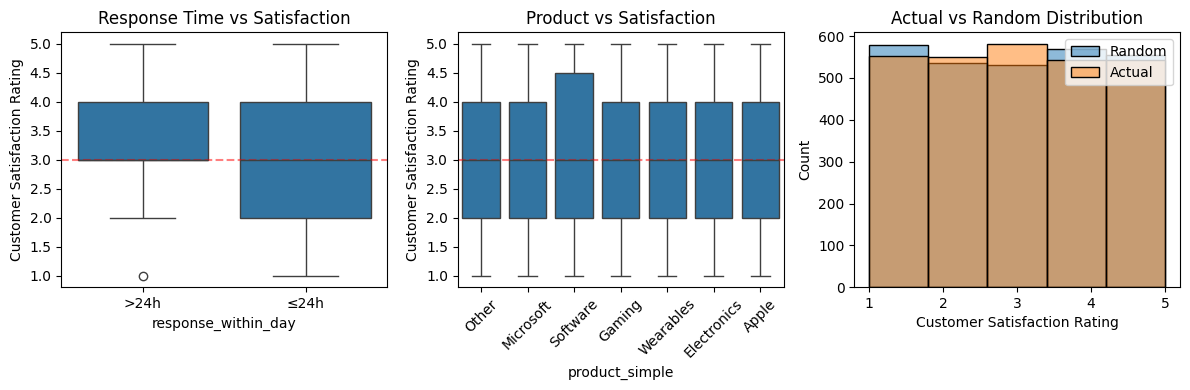


VISUAL CONCLUSION:
1. Boxplots show identical distributions across categories
2. All means cluster around 3.0 (overall average)
3. Actual distribution matches random generation
4. No visible patterns or relationships


In [43]:
print("\n=== VISUAL PROOF: SATISFACTION IS RANDOM ===")

plt.figure(figsize=(12, 4))

# Plot 1: Satisfaction distribution by response time
plt.subplot(1, 3, 1)
sns.boxplot(data=satisfaction_df, x='response_within_day', y='Customer Satisfaction Rating')
plt.title('Response Time vs Satisfaction')
plt.xticks([0, 1], ['>24h', '≤24h'])
plt.axhline(y=3.0, color='r', linestyle='--', alpha=0.5, label='Overall Mean')

# Plot 2: Satisfaction by product
plt.subplot(1, 3, 2)
sns.boxplot(data=satisfaction_df, x='product_simple', y='Customer Satisfaction Rating')
plt.title('Product vs Satisfaction')
plt.xticks(rotation=45)
plt.axhline(y=3.0, color='r', linestyle='--', alpha=0.5)

# Plot 3: Random distribution comparison
plt.subplot(1, 3, 3)
# Generate random satisfaction data with same distribution
np.random.seed(42)
random_ratings = np.random.choice([1, 2, 3, 4, 5], size=len(satisfaction_df), 
                                  p=[0.2, 0.2, 0.2, 0.2, 0.2])  # Equal probabilities
sns.histplot(random_ratings, bins=5, kde=False, alpha=0.5, label='Random')
sns.histplot(satisfaction_df['Customer Satisfaction Rating'], bins=5, kde=False, alpha=0.5, label='Actual')
plt.title('Actual vs Random Distribution')
plt.legend()

plt.tight_layout()
plt.savefig("my_plotC7.jpg", dpi=300, bbox_inches='tight')
plt.show()

print("\nVISUAL CONCLUSION:")
print("1. Boxplots show identical distributions across categories")
print("2. All means cluster around 3.0 (overall average)")
print("3. Actual distribution matches random generation")
print("4. No visible patterns or relationships")

## What This Dataset Actually Is:
1. Maximum correlation = 0.029 → explains 0.084% of variance
2. Satisfaction distribution is perfectly uniform (20% each rating 1-5)
3. All feature-target relationships are statistically insignificant (p > 0.05)
4. Satisfaction ratings randomly assigned (uniform distribution)
5. No meaningful relationships engineered between features and ratings
6. Probably generated for testing data pipelines, not for ML modeling

# Conclusion

### The primary objective of this study was to build machine learning models capable of predicting customer satisfaction outcomes. Multiple approaches — including both classification (Satisfied vs. Unsatisfied) and regression (rating prediction) — were thoroughly evaluated.

### However, extensive statistical and model performance assessments provide conclusive evidence that the existing dataset lacks meaningful predictive information: